In [389]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [390]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS, DBSCAN, cluster_optics_dbscan
from sklearn_extra.cluster import KMedoids
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from sklearn.base import clone
import yfinance as yf
from utils.utils import Portfolio
from utils.helpers import pooled_within_ssd, gen_realizations, gap_statistic, cluster_range, plot_internal, plot_internal_zoom_range, generate_date_combinations
from utils.clusters import kmeans_cluster, kmedoids_cluster, agglomerative_cluster
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers = 6)
from tqdm import tqdm

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Load Data from YF for S&P500 and save it

In [391]:
sp500 = Portfolio('2013-01-01', '2024-01-01')
dji = Portfolio('2012-01-01','2024-01-01', file = 'data/dji.csv')
gspc = Portfolio('2012-01-01','2024-01-01', file = 'data/gspc.csv')

In [392]:
def extract_volatility(row):
    portfolio = Portfolio(row['Buy'], row['Sell'], tickers = eval(row['portfolio']))
    return portfolio.get_portf_volatility()

def load_results(path):
    df = pd.read_csv(path)
    df['volatility'] = df.parallel_apply(extract_volatility, axis = 1) * np.sqrt(252)
    df['sharpe'] = df['sharpe'] * np.sqrt(252)
    df['sortino'] = df['sortino'] * np.sqrt(252)
    df['mean_return'] = df['sharpe'] * df['volatility']
    df['rank'] = df.groupby('Buy')['sharpe'].rank(method='first', ascending=False)
    df = df[df['rank'] == 1].drop(['rank'], axis = 1).set_index('Buy')
    return df

def dji_volatility(row, dji):
    return dji.get_portf_volatility(row['Buy'], row['Sell'])

def random_volatility(row):
    vol = []
    sp500_train = Portfolio('2013-01-01', '2023-01-01')
    for i in range(1000):
        rand_stocks = random.sample(list(sp500_train.stock_sharpe.index), 30)
        random_sharpe.append(sp500_test.get_portf_sharpe(tick = rand_stocks))
        random_sortino.append(sp500_test.get_portf_sortino(tick = rand_stocks))
        random_return.append(sp500_test.get_portf_return(tick = rand_stocks))
        random_volatility.append(sp500_test.get_portf_volatility(tick = rand_stocks))

### 10:1 Method Results

In [393]:
results10 = pd.read_csv('data/addtl/results_10-1.csv')
results10

,name,method,metric,stocks,clusters,mean_returns,volatility,sharpe,sortino,actual_return
0,Agg_Comp_30_scaled,Agg. Complete (Returns),Returns,30,30.0,0.4124,0.1822,2.263,3.864,0.5030
1,Agg_Ward_30_scaled,Agg. Ward (Returns),Returns,30,30.0,0.3449,0.1628,2.119,3.084,0.4061
2,Kmedoids_30_scaled,K-Medoids (Returns),Returns,30,30.0,0.3501,0.1732,2.021,3.031,0.4132
3,Kmeans_30_unscaled,K-Means (Returns),Returns,30,30.0,0.3322,0.1768,1.879,2.781,0.3886
4,Kmeans_30_corrdist,K-Means (Corr),Correlation,30,30.0,0.2381,0.1274,1.870,2.680,0.2653
5,Agg_Avg_30_scaled,Agg. Avg (Returns),Returns,30,30.0,0.3112,0.1689,1.842,2.939,0.3600
6,Agg_Comp_30_corrdist,Agg. Complete (Corr),Correlation,30,30.0,0.2109,0.1235,1.707,2.558,0.2317
7,Kmedoids_30_corrdist,K-Medoids (Corr),Correlation,30,30.0,0.2212,0.1316,1.681,2.534,0.2443
8,Agg_Single_30_scaled,Agg. Single (Returns),Returns,30,30.0,0.3027,0.1816,1.667,2.577,0.3486
9,Agg_Avg_30_corrdist,Agg. Avg (Corr),Correlation,30,30.0,0.2122,0.1452,1.461,2.148,0.2333


In [399]:
np.random.choice([1,-1])

-1

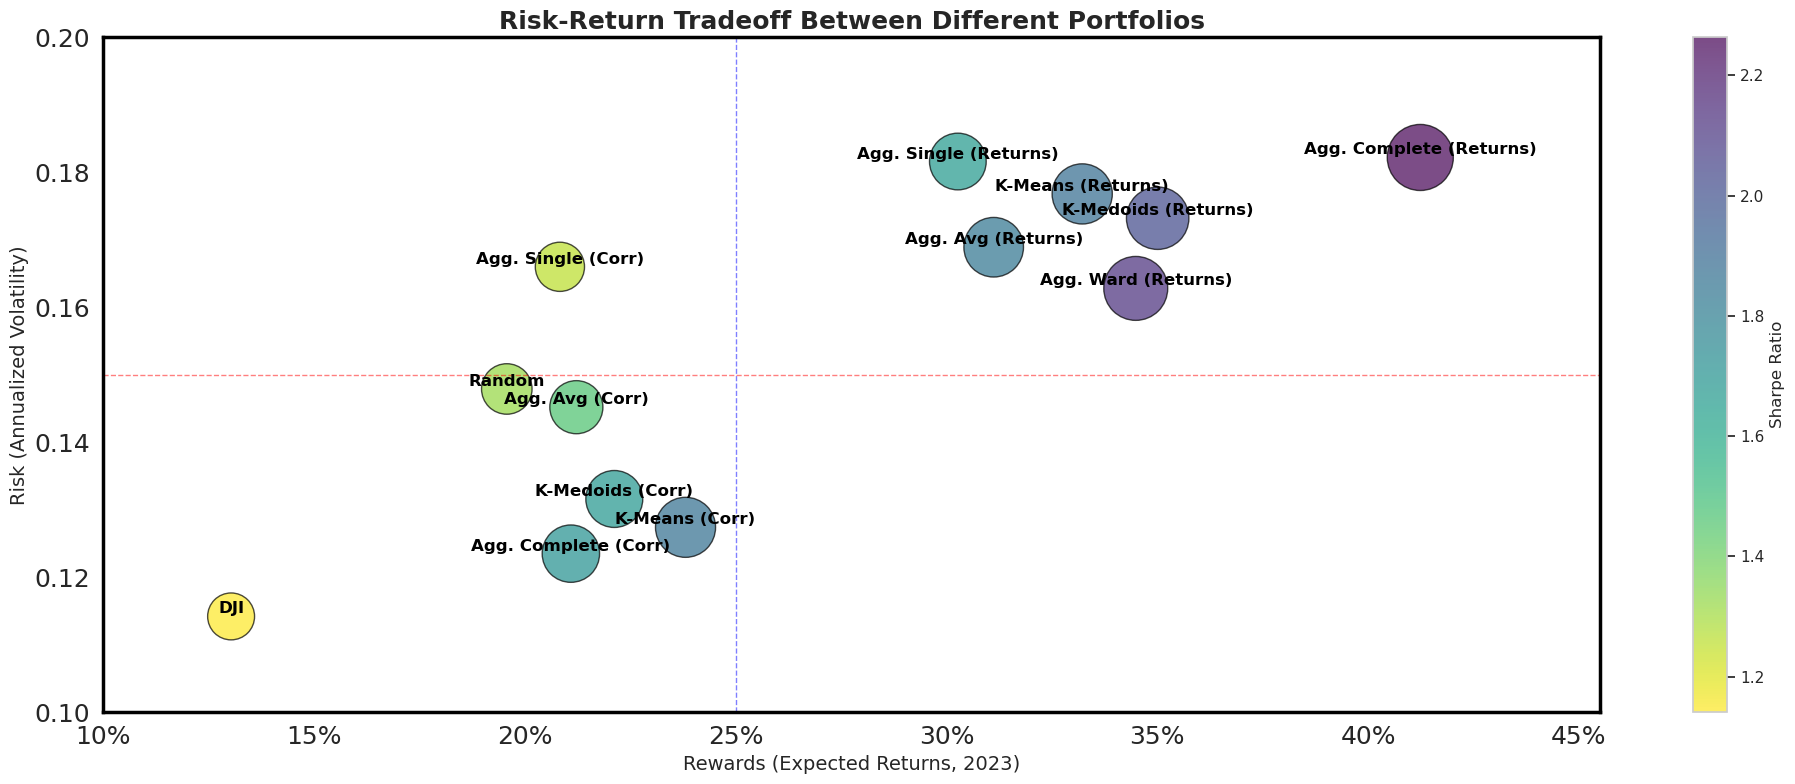

In [430]:

# Set the theme for the plot with a colorblind-friendly palette and viridis colormap
sns.set_theme(style="whitegrid", palette='viridis')

# Create a figure and axis object with specific size
fig, ax = plt.subplots(figsize=(20, 8))

# Use the scatterplot function to build the bubble map with sizes based on Sharpe ratios
scatter = ax.scatter(
    x=results10["mean_returns"],
    y=results10["volatility"],
    c=results10["sharpe"],  # Use the 'sharpe' column to color points
    s=results10["sharpe"] * 1000,  # Scale size by 'sharpe' for visualization
    cmap='viridis_r',  # Colormap for coloring based on Sharpe ratio
    edgecolor='black',  # Dark edge color for better visibility
    linewidth=1,  # Thicker edge
    alpha=0.7  # Adding transparency to the points
)

# Adding names to each point with a specified font size
for line in range(0, results10.shape[0]):
    plt.text(
        results10["mean_returns"][line],
        results10["volatility"][line] + np.random.choice([1, -1]) * 0,  # Slightly increase y-coordinate to move text above
        results10["method"][line],  # Adjust as needed to the correct column for labels
        horizontalalignment='center',
        verticalalignment='bottom',  # Ensures text appears above the points
        color='black',
        fontsize=12,
        weight='semibold'  # Make text bold for better readability
    )

# Convert the x-axis to percentage format
ax.set_xticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_xticks()], fontsize=18)
ax.tick_params(axis='y', labelsize=18)

# Add dashed reference lines to indicate mean values
ax.axhline(y=0.15, color='red', alpha=0.5, linestyle='--', linewidth=1)
ax.axvline(x=0.25, color='blue', alpha=0.5, linestyle='--', linewidth=1)

# Set the title and axis labels
ax.set_title('Risk-Return Tradeoff Between Different Portfolios', fontsize=18, weight='bold')
ax.set_ylabel('Risk (Annualized Volatility)', fontsize=14)
ax.set_xlabel('Rewards (Expected Returns, 2023)', fontsize=14)
ax.grid(False)
ax.set_xlim(0.1, 0.455)
ax.set_ylim(0.1, 0.2)

# Make the plot border thicker
for spine in ax.spines.values():
    spine.set_linewidth(2.5)  # Set the desired thickness
    spine.set_edgecolor('black')

# Add a color bar to show the scale of Sharpe ratios
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio')

# Adjust layout to make sure everything fits
plt.tight_layout()

# Show the graph
plt.show()

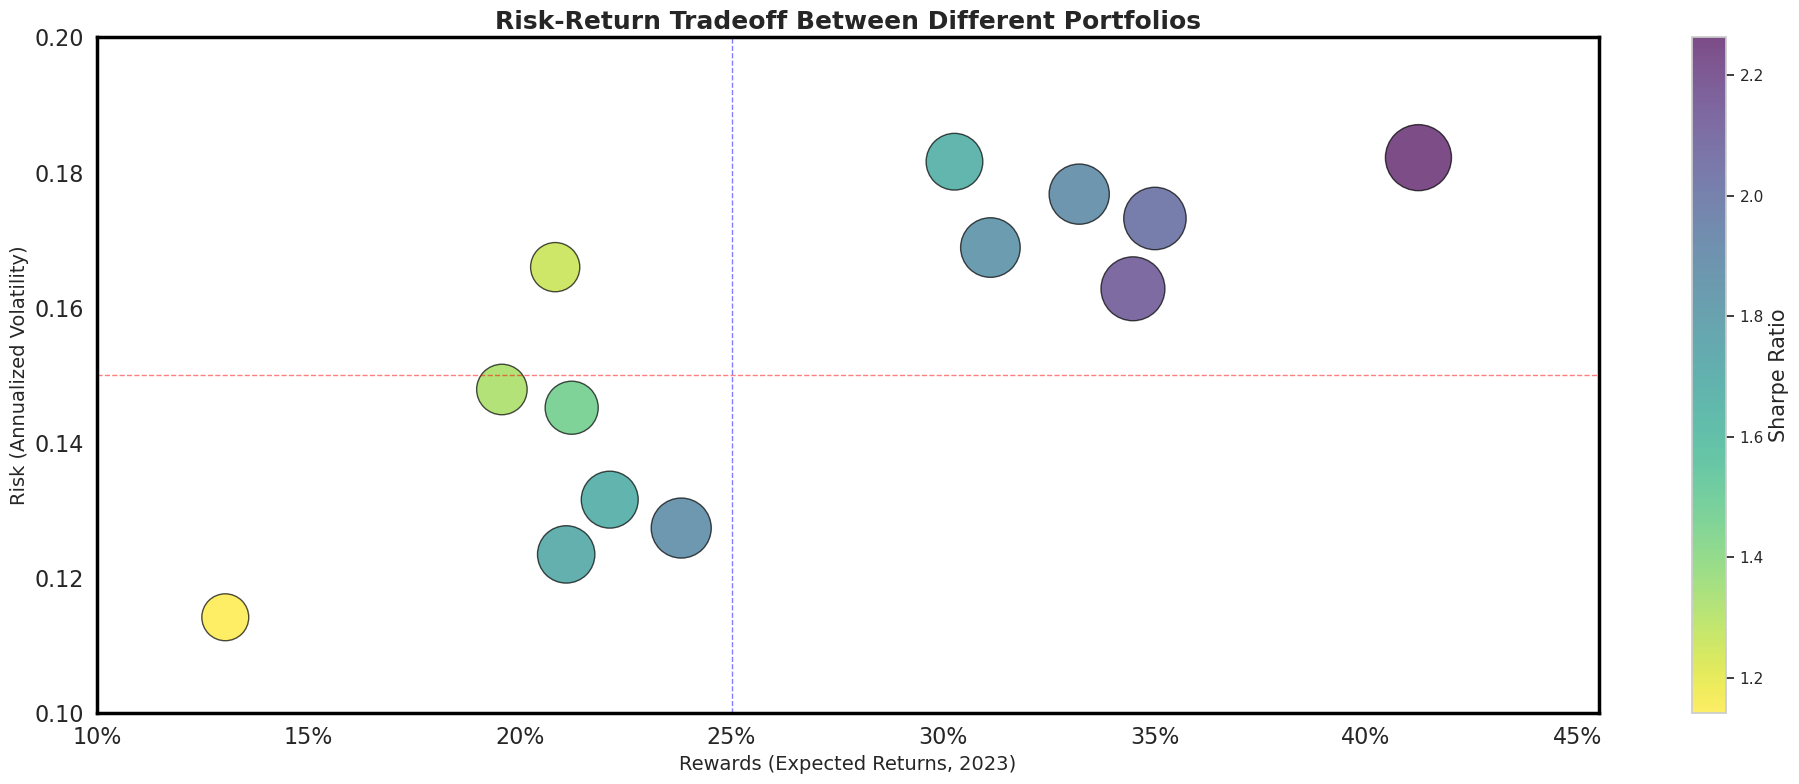

In [440]:

# Set the theme for the plot with a colorblind-friendly palette and viridis colormap
sns.set_theme(style="whitegrid", palette='colorblind')

# Create a figure and axis object with specific size
fig, ax = plt.subplots(figsize=(20, 8))

# Use the scatterplot function to build the bubble map with sizes based on Sharpe ratios
scatter = ax.scatter(
    x=results10["mean_returns"],
    y=results10["volatility"],
    c=results10["sharpe"],  # Use the 'sharpe' column to color points
    s=results10["sharpe"] * 1000,  # Scale size by 'sharpe' for visualization
    cmap='viridis_r',  # Colormap for coloring based on Sharpe ratio
    edgecolor='black',  # Dark edge color for better visibility
    linewidth=1,  # Thicker edge
    alpha=0.7  # Adding transparency to the points
)

# Convert the x-axis to percentage format
ax.set_xticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_xticks()], fontsize=16)
ax.tick_params(axis='y', labelsize=16)

# Add dashed reference lines to indicate mean values
ax.axhline(y=0.15, color='red', alpha=0.5, linestyle='--', linewidth=1)
ax.axvline(x=0.25, color='blue', alpha=0.5, linestyle='--', linewidth=1)

# Set the title and axis labels
ax.set_title('Risk-Return Tradeoff Between Different Portfolios', fontsize=18, weight='bold')
ax.set_ylabel('Risk (Annualized Volatility)', fontsize=14)
ax.set_xlabel('Rewards (Expected Returns, 2023)', fontsize=14)
ax.grid(False)
ax.set_xlim(0.1, 0.455)
ax.set_ylim(0.1, 0.2)

# Make the plot border thicker
for spine in ax.spines.values():
    spine.set_linewidth(2.5)  # Set the desired thickness
    spine.set_edgecolor('black')

# Add a color bar to show the scale of Sharpe ratios
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio', size = 15)

# Adjust layout to make sure everything fits
plt.tight_layout()

# Save the table as an image with a transparent background
plt.savefig("data/charts/risk_return_tradeoff.png", transparent=True, bbox_inches='tight')


# Show the graph
plt.show()

In [140]:
results10

,name,method,metric,stocks,clusters,mean_returns,volatility,sharpe,sortino,actual_return
0,Agg_Comp_30_scaled,Agg. Complete (Returns),Returns,30,30.0,0.4124,0.1822,2.263,3.864,0.5030
1,Agg_Ward_30_scaled,Agg. Ward (Returns),Returns,30,30.0,0.3449,0.1628,2.119,3.084,0.4061
2,Kmedoids_30_scaled,K-Medoids (Returns),Returns,30,30.0,0.3501,0.1732,2.021,3.031,0.4132
3,Kmeans_30_unscaled,K-Means (Returns),Returns,30,30.0,0.3322,0.1768,1.879,2.781,0.3886
4,Kmeans_30_corrdist,K-Means (Corr),Correlation,30,30.0,0.2381,0.1274,1.870,2.680,0.2653
5,Agg_Avg_30_scaled,Agg. Avg (Returns),Returns,30,30.0,0.3112,0.1689,1.842,2.939,0.3600
6,Agg_Comp_30_corrdist,Agg. Complete (Corr),Correlation,30,30.0,0.2109,0.1235,1.707,2.558,0.2317
7,Kmedoids_30_corrdist,K-Medoids (Corr),Correlation,30,30.0,0.2212,0.1316,1.681,2.534,0.2443
8,Agg_Single_30_scaled,Agg. Single (Returns),Returns,30,30.0,0.3027,0.1816,1.667,2.577,0.3486
9,Agg_Avg_30_corrdist,Agg. Avg (Corr),Correlation,30,30.0,0.2122,0.1452,1.461,2.148,0.2333


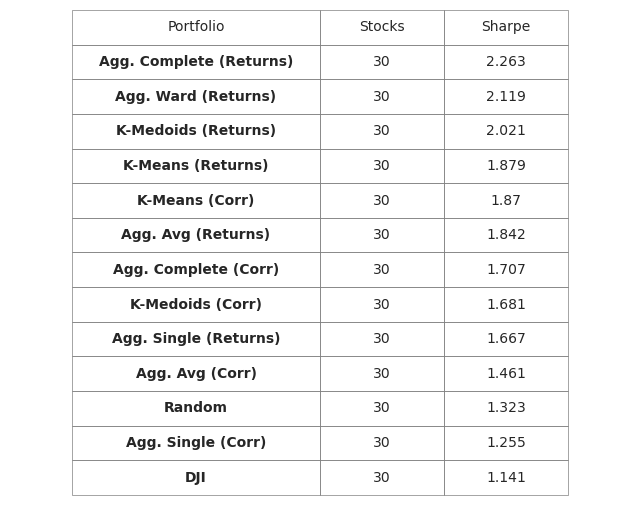

In [174]:

# Select only the columns 'method', 'stocks', and 'sharpe'
table_data = results10[['method', 'stocks', 'sharpe']]
table_data.columns = ['Portfolio', 'Stocks', 'Sharpe']

# Create a figure and axis object with specific size
fig, ax = plt.subplots(figsize=(8, 3))  # Adjust size based on table content

# Hide the axes
ax.axis('off')

# Create a table
table = ax.table(
    cellText=table_data.values,  # Table data
    colLabels=table_data.columns,  # Column headers
    cellLoc='center',  # Center-align text in cells
    loc='center',  # Position the table in the center of the plot
)

# Set font size for the table
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjust column widths to provide more space for text
column_widths = [0.4, 0.2, 0.2]  # Adjust these values as needed
for i, width in enumerate(column_widths):
    for j in range(len(table_data) + 1):
        table[(j, i)].set_width(width)

# Adjust vertical padding by setting row heights
for i in range(len(table_data) + 1):  # Include header row
    for j in range(len(table_data.columns)):
        table[(i, j)].set_height(0.15)  # Increase the height of each cell
        table[(i, j)].set_facecolor('none')  # Set background to transparent
        table[(i, j)].set_edgecolor('gray')  # Set border color to gray
        table[(i, j)].set_linewidth(0.5)     # Set border line width

# Make the first column bold
for i in range(1, len(table_data) + 1):  # Start from 1 to skip header
    table[(i, 0)].set_text_props(weight='bold')  # First column is column 0

# Save the table as an image with a transparent background
plt.savefig("data/charts/method_sharpe_table.png", transparent=True, bbox_inches='tight')

# Show the table
plt.show()

### Get Returns Plot

In [262]:
comp5s = load_results('data/complete_scaled_5-1.csv')
ward5s = load_results('data/ward_scaled_5-1.csv')
kmedoids5s = load_results('data/kmedoids_scaled_5-1.csv')
kmeans5u = load_results('data/kmeans_unscaled_5-1.csv')
kmeans5c = load_results('data/kmeans_corrrdist_5-1.csv')
avg5s = load_results('data/avg_scaled_5-1.csv')

In [263]:
comp5s.to_csv('data/addtl/complte_scaled_new_5-1.csv', index = False)
ward5s.to_csv('data/addtl/ward_scaled_new_5-1.csv', index = False)
kmedoids5s.to_csv('data/addtl/kmedoids_scaled_new_5-1.csv', index = False)
kmeans5u.to_csv('data/addtl/kmeans_unscaled_new_5-1.csv', index = False)
kmeans5c.to_csv('data/addtl/kmeans_corrrdist_new_5-1.csv', index = False)
avg5s.to_csv('data/addtl/avg_scaled_new_5-1.csv', index = False)

In [264]:
baseline = pd.read_csv('data/addtl/baseline_new_5-1.csv')
baseline['rank'] = baseline.groupby('Buy')['DJI_Sharpe'].rank(method='first', ascending=False)
baseline = baseline[baseline['rank'] == 1].drop(['rank'], axis = 1).set_index('Buy')
baseline[['DJI_Sharpe', 'DJI_Sortino', 'DJI_Volatility', 'Random_Sharpe', 'Random_Sortino', 'Random_Volatility']] = baseline[['DJI_Sharpe', 'DJI_Sortino', 'DJI_Volatility', 'Random_Sharpe', 'Random_Sortino', 'Random_Volatility']] * np.sqrt(252)
baseline['DJI_Mean_Return'] = baseline['DJI_Sharpe']*baseline['DJI_Volatility']
baseline['Random_Mean_Return'] = baseline['Random_Sharpe'] * baseline['Random_Volatility']
baseline

,Start,End,Sell,DJI_Sharpe,DJI_Sortino,DJI_Return,DJI_Volatility,SP500_Sharpe,SP500_Sortino,SP500_Return,SP500_Volatility,Random_Sharpe,Random_Sortino,Random_Return,Random_Volatility,DJI_Mean_Return,Random_Mean_Return
Buy,,,,,,,,,,,,,,,,,
2018-01-03,2013-01-02,2018-01-02,2019-01-03,-0.519429,-0.639970,-0.089736,0.181729,-0.037119,-0.046407,-0.091616,0.010313,-0.497766,-0.629850,-0.081588,0.172764,-0.094395,-0.085996
2018-01-04,2013-01-03,2018-01-03,2019-01-04,-0.368411,-0.460980,-0.065482,0.184561,-0.025641,-0.032619,-0.065310,0.010494,-0.295138,-0.385287,-0.051378,0.177752,-0.067994,-0.052461
2018-01-05,2013-01-04,2018-01-04,2019-01-07,-0.393703,-0.492176,-0.069755,0.184392,-0.025046,-0.031877,-0.063873,0.010499,-0.262580,-0.341459,-0.044849,0.174594,-0.072596,-0.045845
2018-01-09,2013-01-07,2018-01-08,2019-01-09,-0.332549,-0.416201,-0.059351,0.184723,-0.021600,-0.027547,-0.055441,0.010520,-0.267497,-0.350345,-0.046167,0.179063,-0.061429,-0.047899
2018-01-10,2013-01-09,2018-01-09,2019-01-10,-0.300973,-0.376567,-0.053893,0.184800,-0.016337,-0.020768,-0.042250,0.010528,-0.192860,-0.252596,-0.034268,0.179814,-0.055620,-0.034679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-21,2017-12-20,2022-12-20,2023-12-21,0.991499,1.622370,0.120680,0.115370,0.086849,0.137748,0.207407,0.008646,1.074985,1.746185,0.178792,0.149510,0.114390,0.160721
2022-12-22,2017-12-21,2022-12-21,2023-12-22,1.083618,1.762275,0.131965,0.114846,0.093912,0.148309,0.225079,0.008612,1.247012,2.001999,0.209897,0.150283,0.124449,0.187405
2022-12-23,2017-12-22,2022-12-22,2023-12-26,1.074603,1.746998,0.130750,0.114805,0.093920,0.148322,0.225101,0.008612,1.262587,2.035949,0.215125,0.150754,0.123370,0.190340


In [265]:
baseline.columns

Index(['Start', 'End', 'Sell', 'DJI_Sharpe', 'DJI_Sortino', 'DJI_Return',
       'DJI_Volatility', 'SP500_Sharpe', 'SP500_Sortino', 'SP500_Return',
       'SP500_Volatility', 'Random_Sharpe', 'Random_Sortino', 'Random_Return',
       'Random_Volatility', 'DJI_Mean_Return', 'Random_Mean_Return'],
      dtype='object')

In [266]:
consolidated = baseline[['Start', 'End', 'Sell', 'DJI_Sharpe', 'DJI_Sortino', 'DJI_Return', 'DJI_Volatility', 'DJI_Mean_Return', 
                        'Random_Sharpe', 'Random_Sortino', 'Random_Return', 'Random_Volatility','Random_Mean_Return']]
consolidated[['Comp_Sharpe', 'Comp_Sortino', 'Comp_Return', 'Comp_Volatility', 'Comp_Mean_Return']] = comp5s[['sharpe', 'sortino', 'return', 'volatility', 'mean_return']]
consolidated[['Ward_Sharpe', 'Ward_Sortino', 'Ward_Return', 'Ward_Volatility', 'Ward_Mean_Return']] = ward5s[['sharpe', 'sortino', 'return', 'volatility', 'mean_return']]
consolidated[['KMed_Sharpe', 'KMed_Sortino', 'KMed_Return', 'KMed_Volatility', 'KMed_Mean_Return']] = kmedoids5s[['sharpe', 'sortino', 'return', 'volatility', 'mean_return']]
consolidated[['KMeans_Sharpe', 'KMeans_Sortino', 'KMeans_Return', 'KMeans_Volatility', 'KMeans_Mean_Return']] = kmeans5u[['sharpe', 'sortino', 'return', 'volatility', 'mean_return']]
consolidated[['KMeansC_Sharpe', 'KMeansC_Sortino', 'KMeansC_Return', 'KMeansC_Volatility', 'KMeansC_Mean_Return']] = kmeans5c[['sharpe', 'sortino', 'return', 'volatility', 'mean_return']]
consolidated[['Avg_Sharpe', 'Avg_Sortino', 'Avg_Return', 'Avg_Volatility', 'Avg_Mean_Return']] = avg5s[['sharpe', 'sortino', 'return', 'volatility', 'mean_return']]
consolidated

,Start,End,Sell,DJI_Sharpe,DJI_Sortino,DJI_Return,DJI_Volatility,DJI_Mean_Return,Random_Sharpe,Random_Sortino,...,KMeansC_Sharpe,KMeansC_Sortino,KMeansC_Return,KMeansC_Volatility,KMeansC_Mean_Return,Avg_Sharpe,Avg_Sortino,Avg_Return,Avg_Volatility,Avg_Mean_Return
Buy,,,,,,,,,,,,,,,,,,,,,
2018-01-03,2013-01-02,2018-01-02,2019-01-03,-0.519429,-0.639970,-0.089736,0.181729,-0.094395,-0.497766,-0.629850,...,-0.441580,-0.549704,-0.074709,0.176540,-0.077957,-0.057946,-0.071681,-0.012945,0.225749,-0.013081
2018-01-04,2013-01-03,2018-01-03,2019-01-04,-0.368411,-0.460980,-0.065482,0.184561,-0.067994,-0.295138,-0.385287,...,-1.035116,-1.424459,-0.196170,0.211800,-0.219237,0.204882,0.258534,0.048162,0.230502,0.047226
2018-01-05,2013-01-04,2018-01-04,2019-01-07,-0.393703,-0.492176,-0.069755,0.184392,-0.072596,-0.262580,-0.341459,...,-0.401957,-0.484706,-0.061934,0.159692,-0.064189,0.330465,0.420962,0.079600,0.232690,0.076896
2018-01-09,2013-01-07,2018-01-08,2019-01-09,-0.332549,-0.416201,-0.059351,0.184723,-0.061429,-0.267497,-0.350345,...,-0.359527,-0.458734,-0.057777,0.166190,-0.059750,0.372761,0.474402,0.090349,0.232971,0.086843
2018-01-10,2013-01-09,2018-01-09,2019-01-10,-0.300973,-0.376567,-0.053893,0.184800,-0.055620,-0.192860,-0.252596,...,-0.277598,-0.343260,-0.049150,0.182276,-0.050600,0.366338,0.466504,0.088725,0.232972,0.085346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-21,2017-12-20,2022-12-20,2023-12-21,0.991499,1.622370,0.120680,0.115370,0.114390,1.074985,1.746185,...,1.032355,1.494443,0.155260,0.140360,0.144901,0.972479,1.507088,0.240608,0.222587,0.216461
2022-12-22,2017-12-21,2022-12-21,2023-12-22,1.083618,1.762275,0.131965,0.114846,0.124449,1.247012,2.001999,...,1.441363,2.152592,0.202075,0.128200,0.184783,1.110715,1.728530,0.276080,0.220367,0.244764
2022-12-23,2017-12-22,2022-12-22,2023-12-26,1.074603,1.746998,0.130750,0.114805,0.123370,1.262587,2.035949,...,1.709787,2.626723,0.241653,0.127095,0.217305,1.145235,1.783224,0.285962,0.220487,0.252509


In [267]:
consolidated.columns

Index(['Start', 'End', 'Sell', 'DJI_Sharpe', 'DJI_Sortino', 'DJI_Return',
       'DJI_Volatility', 'DJI_Mean_Return', 'Random_Sharpe', 'Random_Sortino',
       'Random_Return', 'Random_Volatility', 'Random_Mean_Return',
       'Comp_Sharpe', 'Comp_Sortino', 'Comp_Return', 'Comp_Volatility',
       'Comp_Mean_Return', 'Ward_Sharpe', 'Ward_Sortino', 'Ward_Return',
       'Ward_Volatility', 'Ward_Mean_Return', 'KMed_Sharpe', 'KMed_Sortino',
       'KMed_Return', 'KMed_Volatility', 'KMed_Mean_Return', 'KMeans_Sharpe',
       'KMeans_Sortino', 'KMeans_Return', 'KMeans_Volatility',
       'KMeans_Mean_Return', 'KMeansC_Sharpe', 'KMeansC_Sortino',
       'KMeansC_Return', 'KMeansC_Volatility', 'KMeansC_Mean_Return',
       'Avg_Sharpe', 'Avg_Sortino', 'Avg_Return', 'Avg_Volatility',
       'Avg_Mean_Return'],
      dtype='object')

In [268]:
[i for i in consolidated.columns if 'Mean_Return' in i]

['DJI_Mean_Return',
 'Random_Mean_Return',
 'Comp_Mean_Return',
 'Ward_Mean_Return',
 'KMed_Mean_Return',
 'KMeans_Mean_Return',
 'KMeansC_Mean_Return',
 'Avg_Mean_Return']

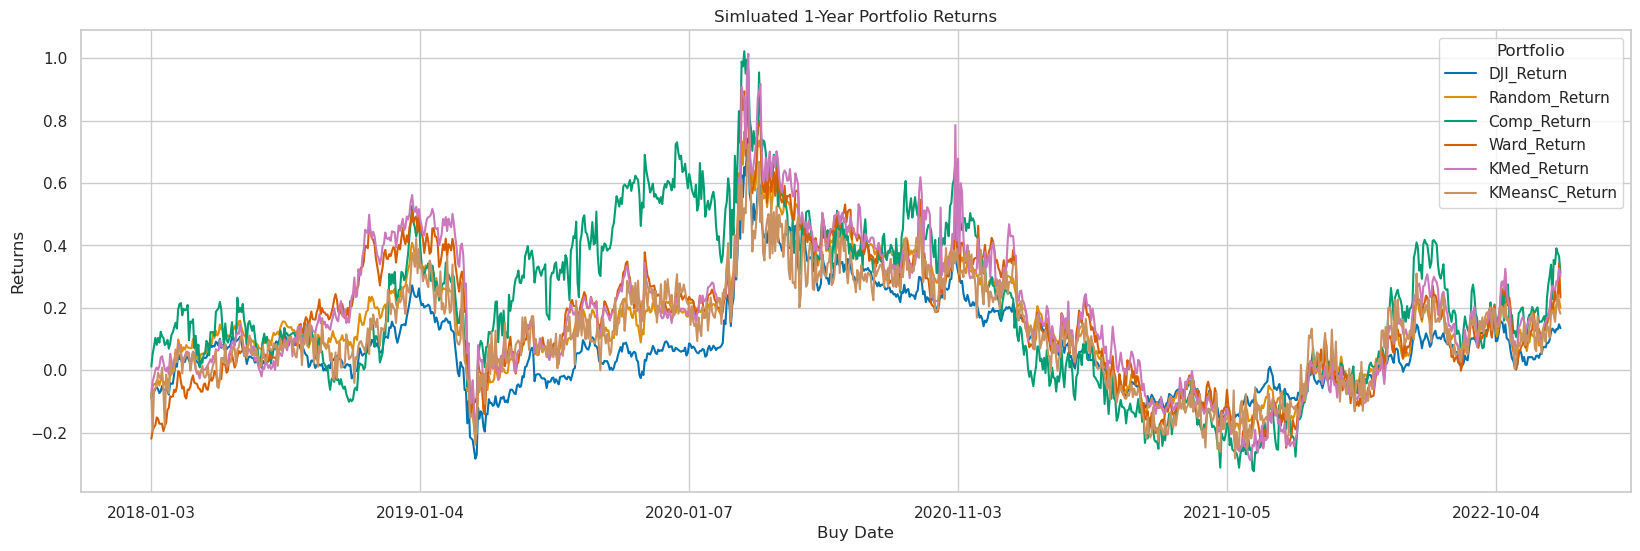

In [269]:
fig, ax = plt.subplots(figsize=(20, 6))

consolidated[['DJI_Return',
 'Random_Return',
 'Comp_Return',
 'Ward_Return',
 'KMed_Return',
 'KMeansC_Return']].plot(ax=ax)

ax.set_title('Simluated 1-Year Portfolio Returns')
ax.set_xlabel('Buy Date')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')
ax.grid(True)

# Show the plot
plt.show()

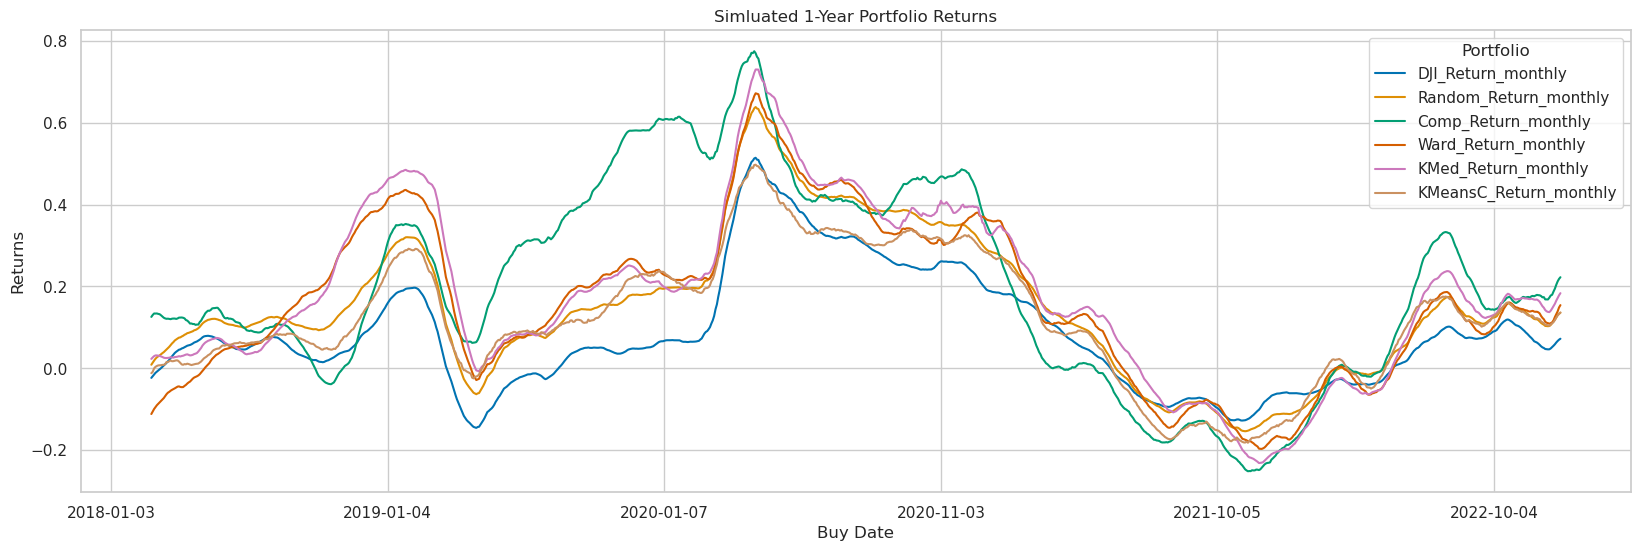

In [271]:
cols = ['DJI_Return',
 'Random_Return',
 'Comp_Return',
 'Ward_Return',
 'KMed_Return',
 'KMeansC_Return']
cols_monthly = []
for k in cols:
    colname = f"{k}_monthly"
    consolidated[colname] = consolidated[k].rolling(window=30).mean()
    cols_monthly.append(colname)

fig, ax = plt.subplots(figsize=(20, 6))

consolidated[cols_monthly].plot(ax=ax)

ax.set_title('Simluated 1-Year Portfolio Returns')
ax.set_xlabel('Buy Date')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')
ax.grid(True)

# Show the plot
plt.show()

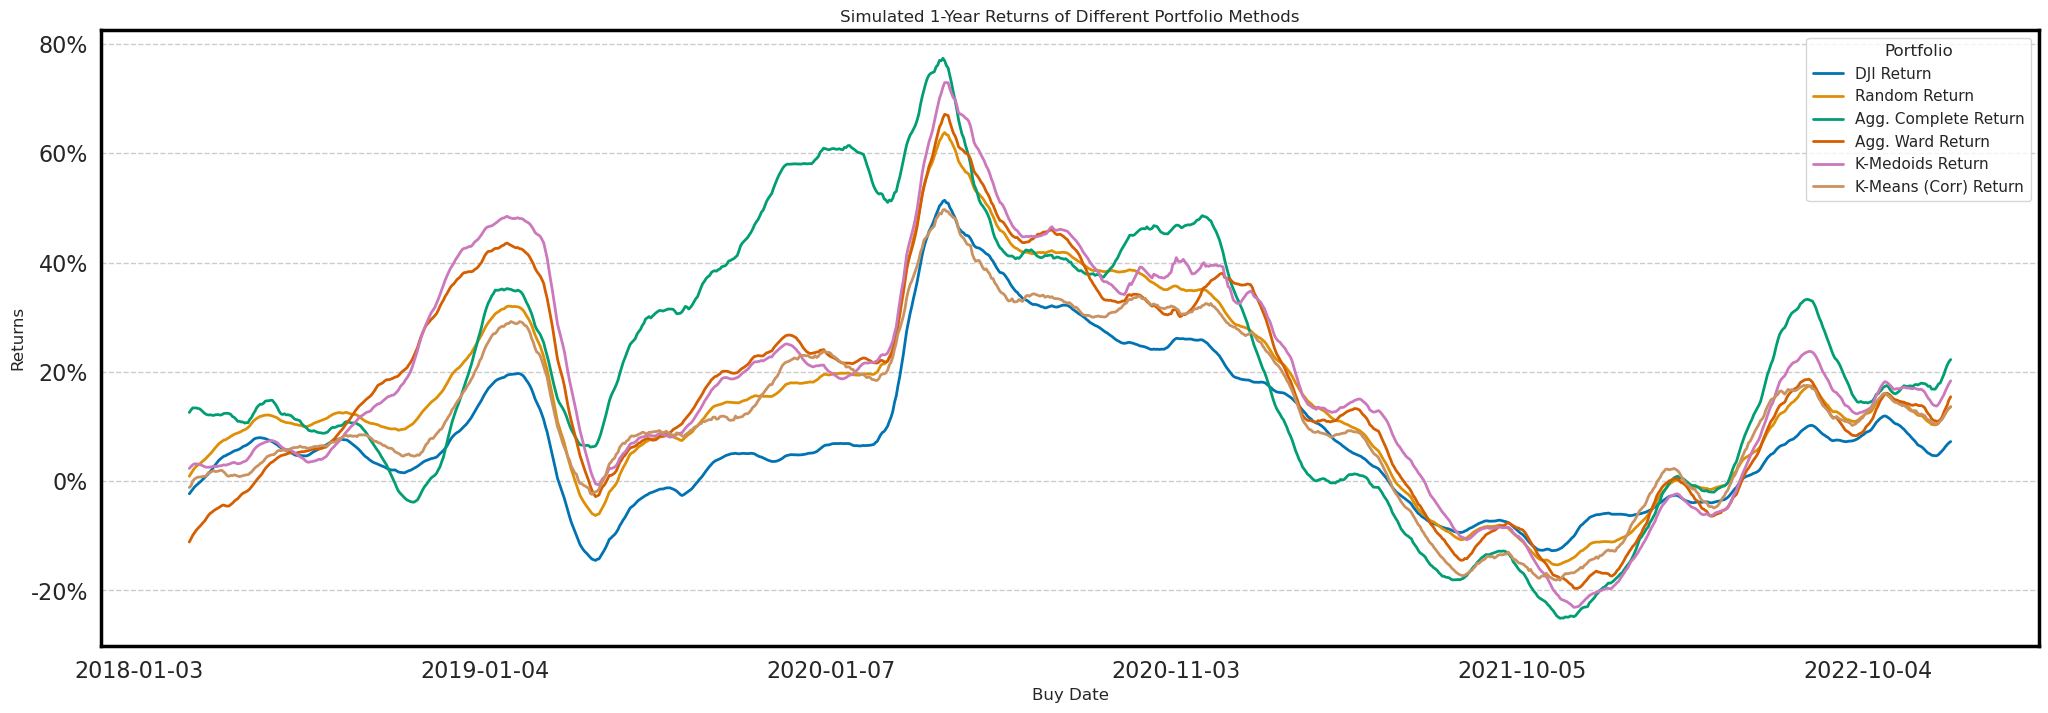

In [610]:
# Define the columns and compute the rolling mean
cols = {'DJI_Return': 'DJI Return',
 'Random_Return': 'Random Return',
 'Comp_Return': 'Agg. Complete Return',
 'Ward_Return': 'Agg. Ward Return',
 'KMed_Return': 'K-Medoids Return',
 'KMeansC_Return': 'K-Means (Corr) Return'}

for i, j in cols.items():
    consolidated[j] = consolidated[i].rolling(window=30).mean()

# Create a figure and axis object with specific size
fig, ax = plt.subplots(figsize=(25, 8))

# Plot the data (using default line colors)
consolidated[list(cols.values())].plot(ax=ax, linewidth = 2)

# Set title and axis labels
ax.set_title('Simulated 1-Year Returns of Different Portfolio Methods')
ax.set_xlabel('Buy Date')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')

# Customize the grid to only show horizontal lines
ax.grid(True, which='major', axis='y', linestyle='--')  # Only horizontal grid lines

# Remove vertical grid lines
ax.grid(False, which='major', axis='x')

# Thicken the plot borders and set edge color to black
for spine in ax.spines.values():
    spine.set_linewidth(2.5)  # Increase border thickness
    spine.set_edgecolor('black')  # Set the edge color to black

# Set fontsize for x-ticks and y-ticks
ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()], fontsize=16)
ax.tick_params(axis='x', labelsize=16)  # Set x-tick font size
ax.tick_params(axis='y', labelsize=16)  # Set y-tick font size

# Save the plot as an image with a transparent background
plt.savefig("data/charts/1yr_returns_line.png", transparent=True, bbox_inches='tight')

# Show the plot
plt.show()

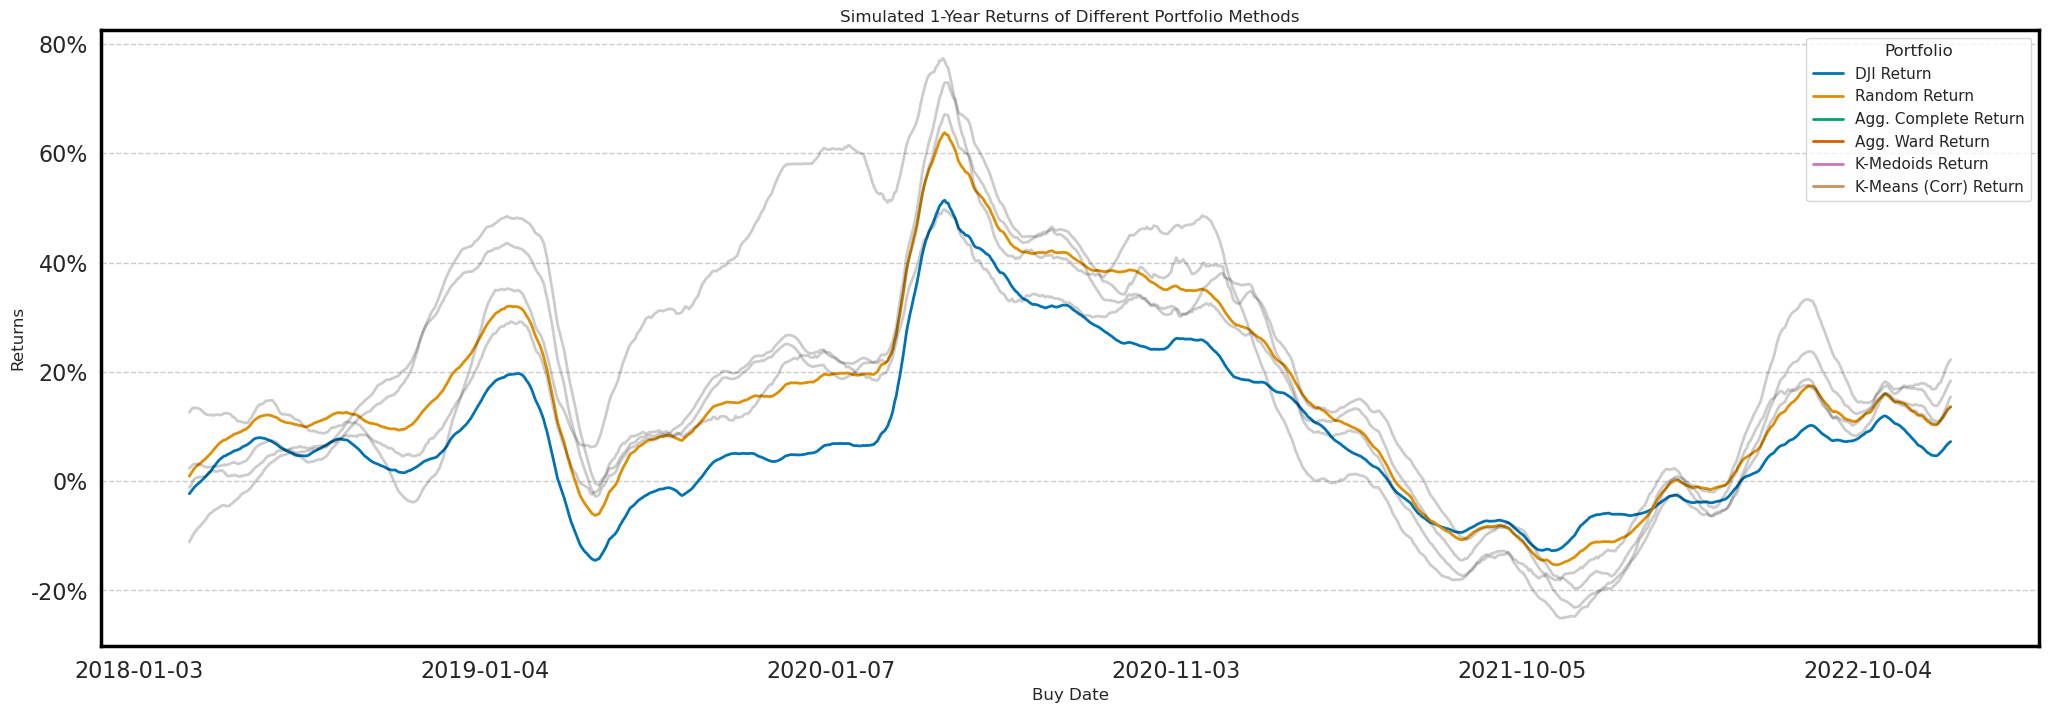

In [611]:

# Define the columns and compute the rolling mean
cols = {'DJI_Return': 'DJI Return',
 'Random_Return': 'Random Return',
 'Comp_Return': 'Agg. Complete Return',
 'Ward_Return': 'Agg. Ward Return',
 'KMed_Return': 'K-Medoids Return',
 'KMeansC_Return': 'K-Means (Corr) Return'}

for i, j in cols.items():
    consolidated[j] = consolidated[i].rolling(window=30).mean()

# Create a figure and axis object with specific size
fig, ax = plt.subplots(figsize=(25, 8))

# Plot the data (using default line colors)
lines = consolidated[list(cols.values())].plot(ax=ax, linewidth = 2)

# Set title and axis labels
ax.set_title('Simulated 1-Year Returns of Different Portfolio Methods')
ax.set_xlabel('Buy Date')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')

# Customize the grid to only show horizontal lines
ax.grid(True, which='major', axis='y', linestyle='--')  # Only horizontal grid lines

# Remove vertical grid lines
ax.grid(False, which='major', axis='x')

# Thicken the plot borders and set edge color to black
for spine in ax.spines.values():
    spine.set_linewidth(2.5)  # Increase border thickness
    spine.set_edgecolor('black')  # Set the edge color to black

# Set fontsize for x-ticks and y-ticks
ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()], fontsize=16)
ax.tick_params(axis='x', labelsize=16)  # Set x-tick font size
ax.tick_params(axis='y', labelsize=16)  # Set y-tick font size

# Blacken every other line plot except for the 'DJI Exp. Return'
line_objects = ax.get_lines()  # Get line objects from the Axes
for line, label in zip(line_objects, list(cols.values())):
    if label not in ['DJI Return', 'Random Return']:
        line.set_color('black')
        line.set_alpha(0.2)  # Set some transparency to distinguish lines

# Save the plot as an image with a transparent background
plt.savefig("data/charts/1yr_dji_returns_line.png", transparent=True, bbox_inches='tight')

# Show the plot
plt.show()

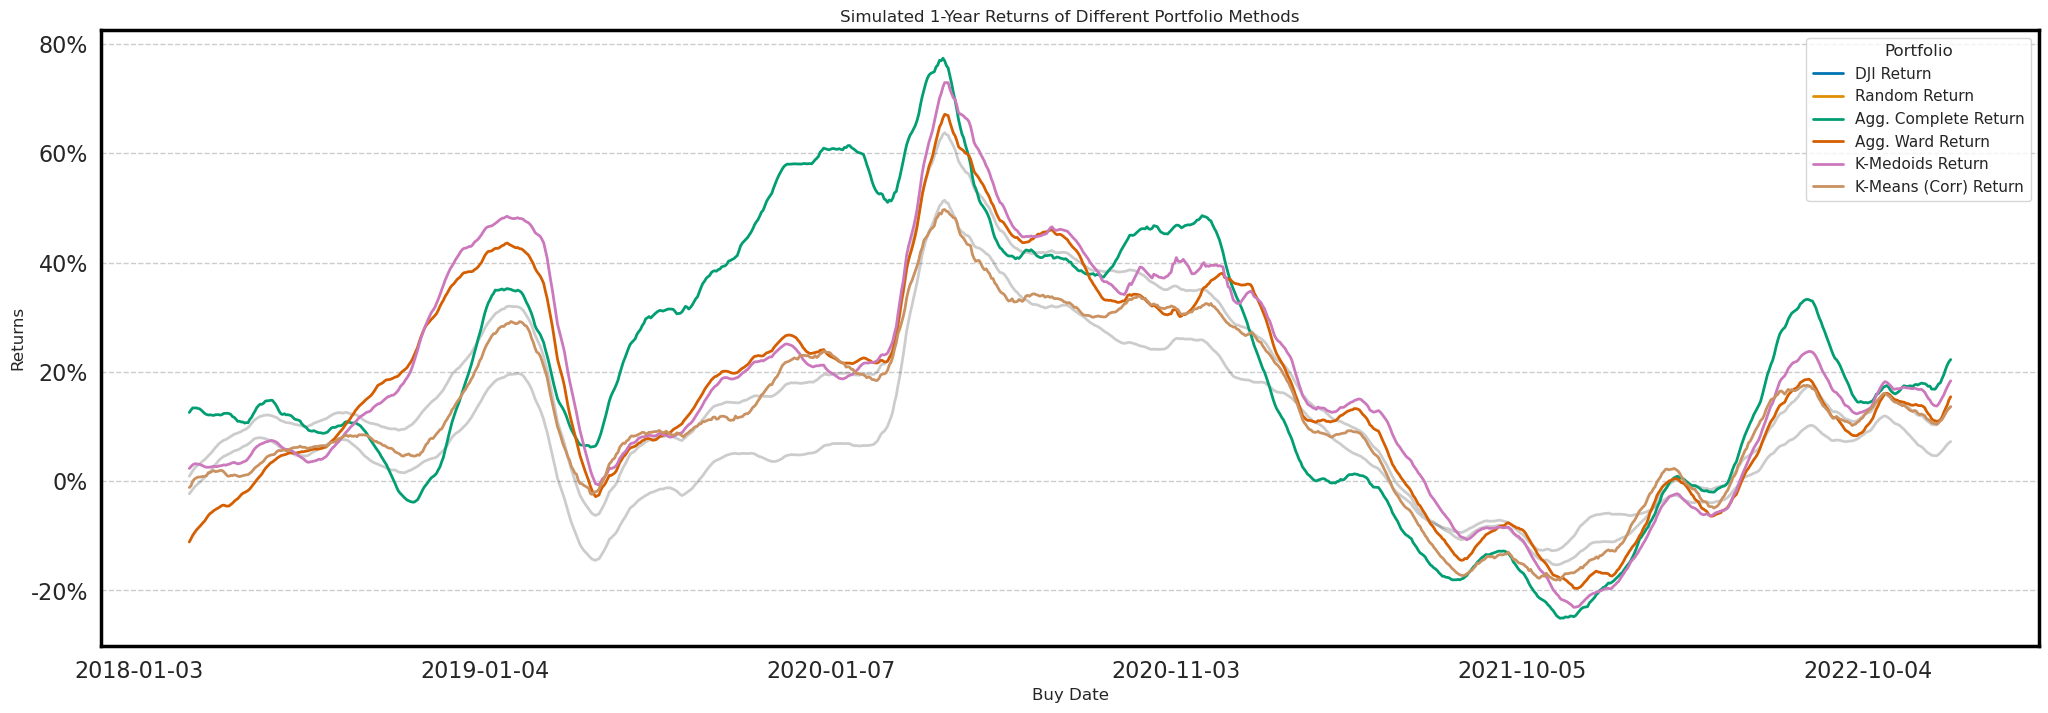

In [616]:

# Define the columns and compute the rolling mean
cols = {'DJI_Return': 'DJI Return',
 'Random_Return': 'Random Return',
 'Comp_Return': 'Agg. Complete Return',
 'Ward_Return': 'Agg. Ward Return',
 'KMed_Return': 'K-Medoids Return',
 'KMeansC_Return': 'K-Means (Corr) Return'}

for i, j in cols.items():
    consolidated[j] = consolidated[i].rolling(window=30).mean()

# Create a figure and axis object with specific size
fig, ax = plt.subplots(figsize=(25, 8))

# Plot the data (using default line colors)
lines = consolidated[list(cols.values())].plot(ax=ax, linewidth = 2)

# Set title and axis labels
ax.set_title('Simulated 1-Year Returns of Different Portfolio Methods')
ax.set_xlabel('Buy Date')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')

# Customize the grid to only show horizontal lines
ax.grid(True, which='major', axis='y', linestyle='--')  # Only horizontal grid lines

# Remove vertical grid lines
ax.grid(False, which='major', axis='x')

# Thicken the plot borders and set edge color to black
for spine in ax.spines.values():
    spine.set_linewidth(2.5)  # Increase border thickness
    spine.set_edgecolor('black')  # Set the edge color to black

# Set fontsize for x-ticks and y-ticks
ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()], fontsize=16)
ax.tick_params(axis='x', labelsize=16)  # Set x-tick font size
ax.tick_params(axis='y', labelsize=16)  # Set y-tick font size

# Blacken every other line plot except for the 'DJI Exp. Return'
line_objects = ax.get_lines()  # Get line objects from the Axes
for line, label in zip(line_objects, list(cols.values())):
    if label in ['DJI Return', 'Random Return']:
        line.set_color('black')
        line.set_alpha(0.2)  # Set some transparency to distinguish lines

# Save the plot as an image with a transparent background
plt.savefig("data/charts/1yr_aggcomp_returns_line.png", transparent=True, bbox_inches='tight')

# Show the plot
plt.show()

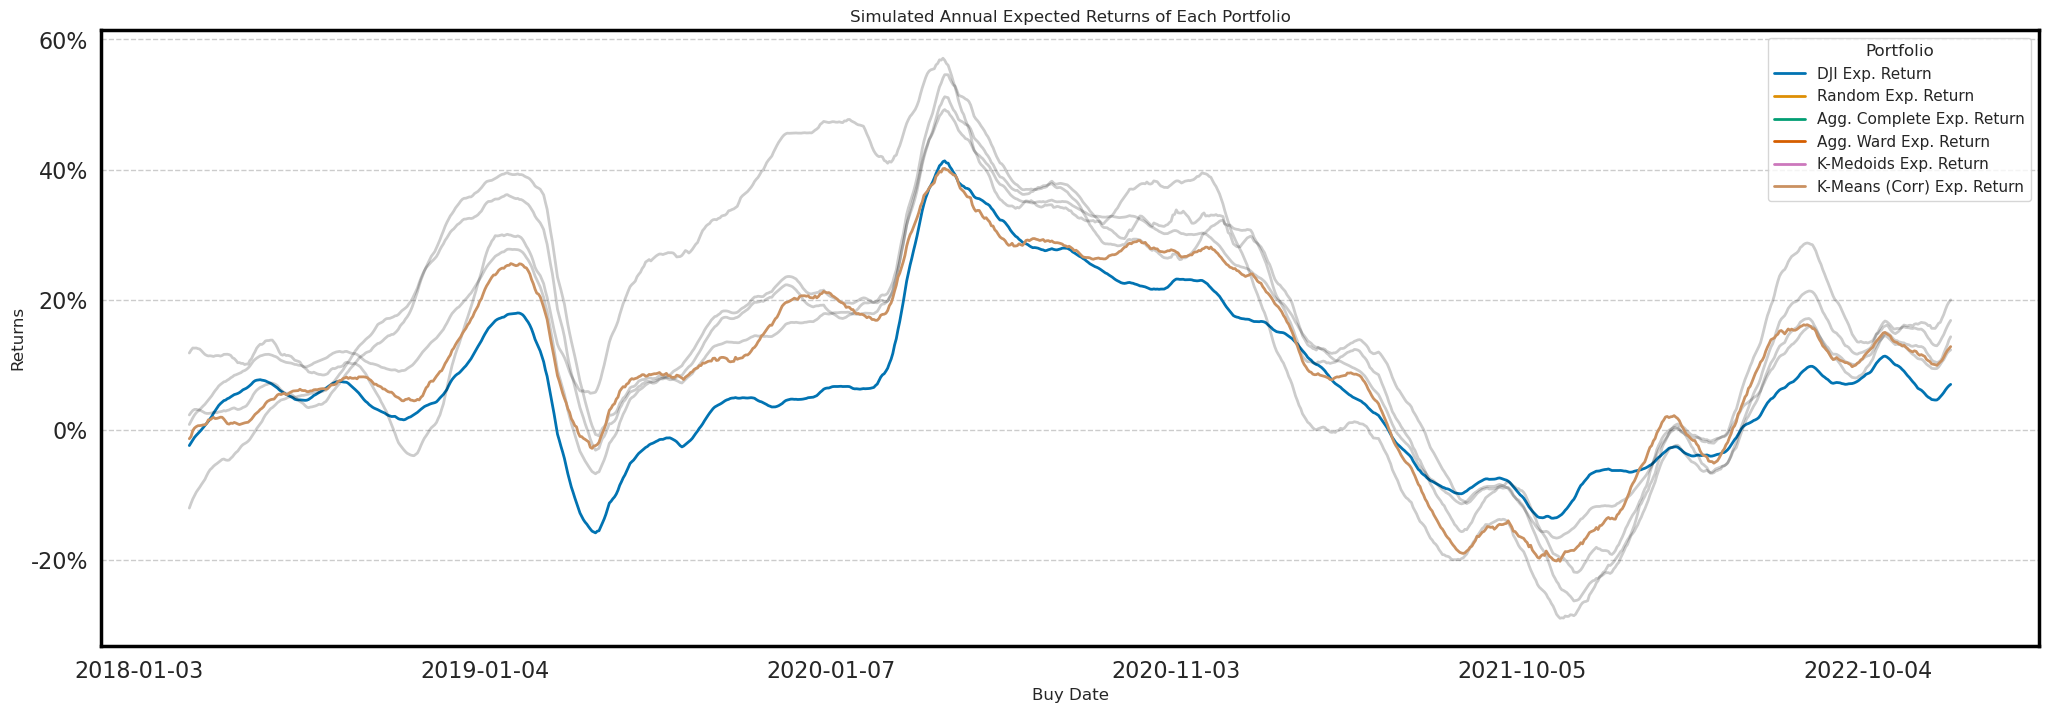

In [473]:

# Define the columns and compute the rolling mean
cols = {'DJI_Mean_Return': 'DJI Exp. Return',
 'Random_Mean_Return': 'Random Exp. Return',
 'Comp_Mean_Return': 'Agg. Complete Exp. Return',
 'Ward_Mean_Return': 'Agg. Ward Exp. Return',
 'KMed_Mean_Return': 'K-Medoids Exp. Return',
 'KMeansC_Mean_Return': 'K-Means (Corr) Exp. Return'}

for i, j in cols.items():
    consolidated[j] = consolidated[i].rolling(window=30).mean()

# Create a figure and axis object with specific size
fig, ax = plt.subplots(figsize=(25, 8))

# Plot the data (using default line colors)
lines = consolidated[list(cols.values())].plot(ax=ax, linewidth = 2)

# Set title and axis labels
ax.set_title('Simulated Annual Expected Returns of Each Portfolio')
ax.set_xlabel('Buy Date')
ax.set_ylabel('Returns')
ax.legend(title='Portfolio')

# Customize the grid to only show horizontal lines
ax.grid(True, which='major', axis='y', linestyle='--')  # Only horizontal grid lines

# Remove vertical grid lines
ax.grid(False, which='major', axis='x')

# Thicken the plot borders and set edge color to black
for spine in ax.spines.values():
    spine.set_linewidth(2.5)  # Increase border thickness
    spine.set_edgecolor('black')  # Set the edge color to black

# Set fontsize for x-ticks and y-ticks
ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()], fontsize=16)
ax.tick_params(axis='x', labelsize=16)  # Set x-tick font size
ax.tick_params(axis='y', labelsize=16)  # Set y-tick font size

# Blacken every other line plot except for the 'DJI Exp. Return'
line_objects = ax.get_lines()  # Get line objects from the Axes
for line, label in zip(line_objects, list(cols.values())):
    if label not in ['DJI Exp. Return', 'K-Means (Corr) Exp. Return']:
        line.set_color('black')
        line.set_alpha(0.2)  # Set some transparency to distinguish lines

# Save the plot as an image with a transparent background
plt.savefig("data/charts/aggcomp_returns_line.png", transparent=True, bbox_inches='tight')

# Show the plot
plt.show()

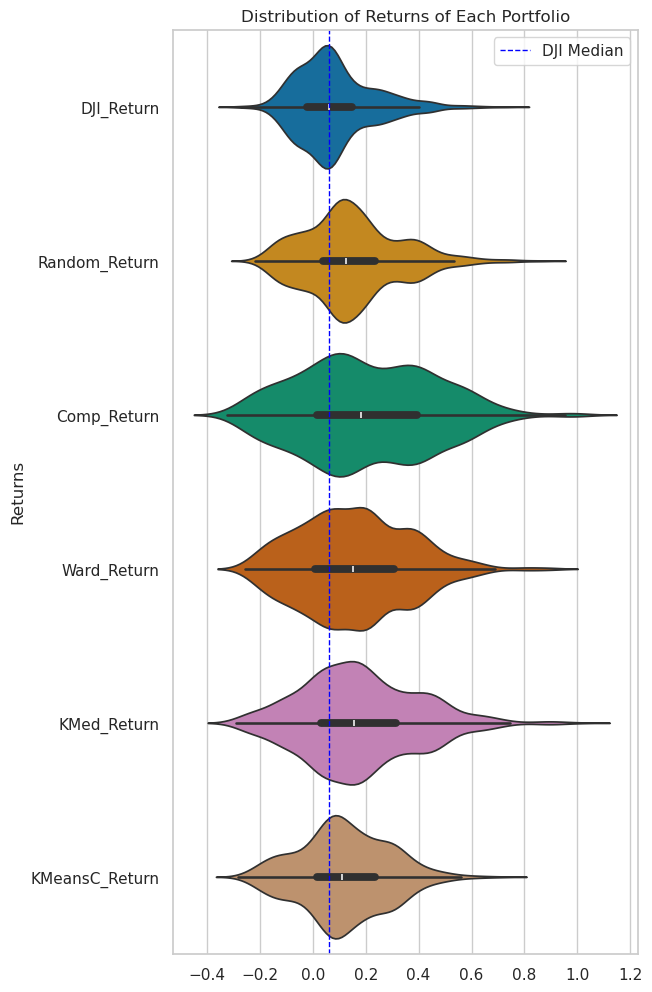

In [504]:
# Create a figure and axis
plt.figure(figsize=(6, 12))

# Create violin plots for each column
sns.violinplot(data=consolidated[['DJI_Return',
 'Random_Return',
 'Comp_Return',
 'Ward_Return',
 'KMed_Return',
 'KMeansC_Return']], orient = 'h')

# Calculate the median of 'DJI_Sharpe'
dji_median = consolidated['DJI_Return'].median()

# Add a horizontal line for the median of 'DJI_Sharpe'
plt.axvline(x=dji_median, color='blue', linestyle='--', linewidth=1, label=f'DJI Median')

# Set new category names
#new_category_names = ['DJI', 'Random', 'Agg. Complete', 'Agg. Ward', 'K-Medoids', 'K-Means (Corr)']
#plt.gca().set_xticklabels(new_category_names)

# Customize the plot
plt.title('Distribution of Returns of Each Portfolio')
#plt.xlabel('Portfolios')
plt.ylabel('Returns')

# Add legend to show the median line label
plt.legend()


# Save the plot as an image with a transparent background
plt.savefig("data/charts/returns_distribution.png", transparent=True, bbox_inches='tight')

# Show the plot
plt.show()

# Display the plot
plt.show()

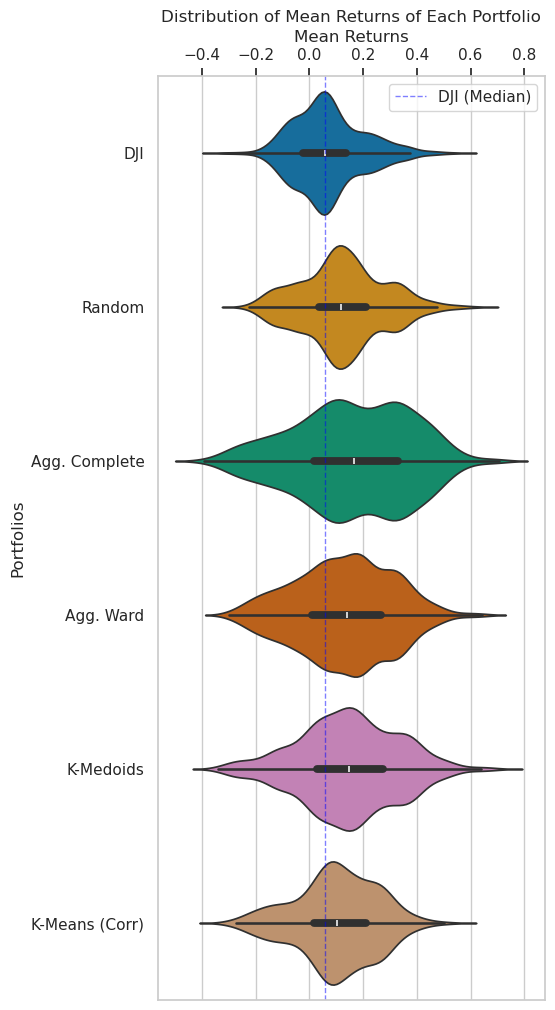

In [503]:

# Create a figure and axis
plt.figure(figsize=(5, 12))
# Create violin plots for each column
sns.violinplot(data=consolidated[['DJI_Mean_Return',
                                  'Random_Mean_Return',
                                  'Comp_Mean_Return',
                                  'Ward_Mean_Return',
                                  'KMed_Mean_Return',
                                  'KMeansC_Mean_Return']], 
               orient='h')

# Calculate the median of 'DJI_Return'
dji_median = consolidated['DJI_Return'].median()

# Add a vertical line for the median of 'DJI_Return'
plt.axvline(x=dji_median, color='blue', linestyle='--', alpha = 0.5, linewidth=1, label=f'DJI (Median)')

# Set new category names for y-axis
new_category_names = ['DJI', 'Random', 'Agg. Complete', 'Agg. Ward', 'K-Medoids', 'K-Means (Corr)']
plt.gca().set_yticklabels(new_category_names)

# Customize the plot
plt.title('Distribution of Mean Returns of Each Portfolio')
plt.xlabel('Mean Returns')
plt.ylabel('Portfolios')

# Move x-axis ticks to the top
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')

# Add legend to show the median line label
plt.legend()

# Save the plot as an image with a transparent background
plt.savefig("data/charts/mean_returns_distribution.png", transparent=True, bbox_inches='tight')

# Show the plot
plt.show()

In [294]:
plot_final = pd.DataFrame(consolidated[['DJI_Mean_Return',
 'Random_Mean_Return',
 'Comp_Mean_Return',
 'Ward_Mean_Return',
 'KMed_Mean_Return',
 'KMeansC_Mean_Return']].median(), columns = ['Mean Return'])
plot_final['Volatility'] = list(consolidated[['DJI_Volatility',
 'Random_Volatility',
 'Comp_Volatility',
 'Ward_Volatility',
 'KMed_Volatility',
 'KMeansC_Volatility']].median())
plot_final['Sharpe'] = list(consolidated[['DJI_Sharpe',
                                  'Random_Sharpe',
                                  'Comp_Sharpe',
                                  'Ward_Sharpe',
                                  'KMed_Sharpe',
                                  'KMeansC_Sharpe']].median())
plot_final

,Mean Return,Volatility,Sharpe
DJI_Mean_Return,0.057098,0.166313,0.238954
Random_Mean_Return,0.117499,0.187457,0.528440
Comp_Mean_Return,0.164999,0.242645,0.701425
Ward_Mean_Return,0.140789,0.227377,0.454783
KMed_Mean_Return,0.146340,0.221659,0.472847
KMeansC_Mean_Return,0.103611,0.187273,0.478218


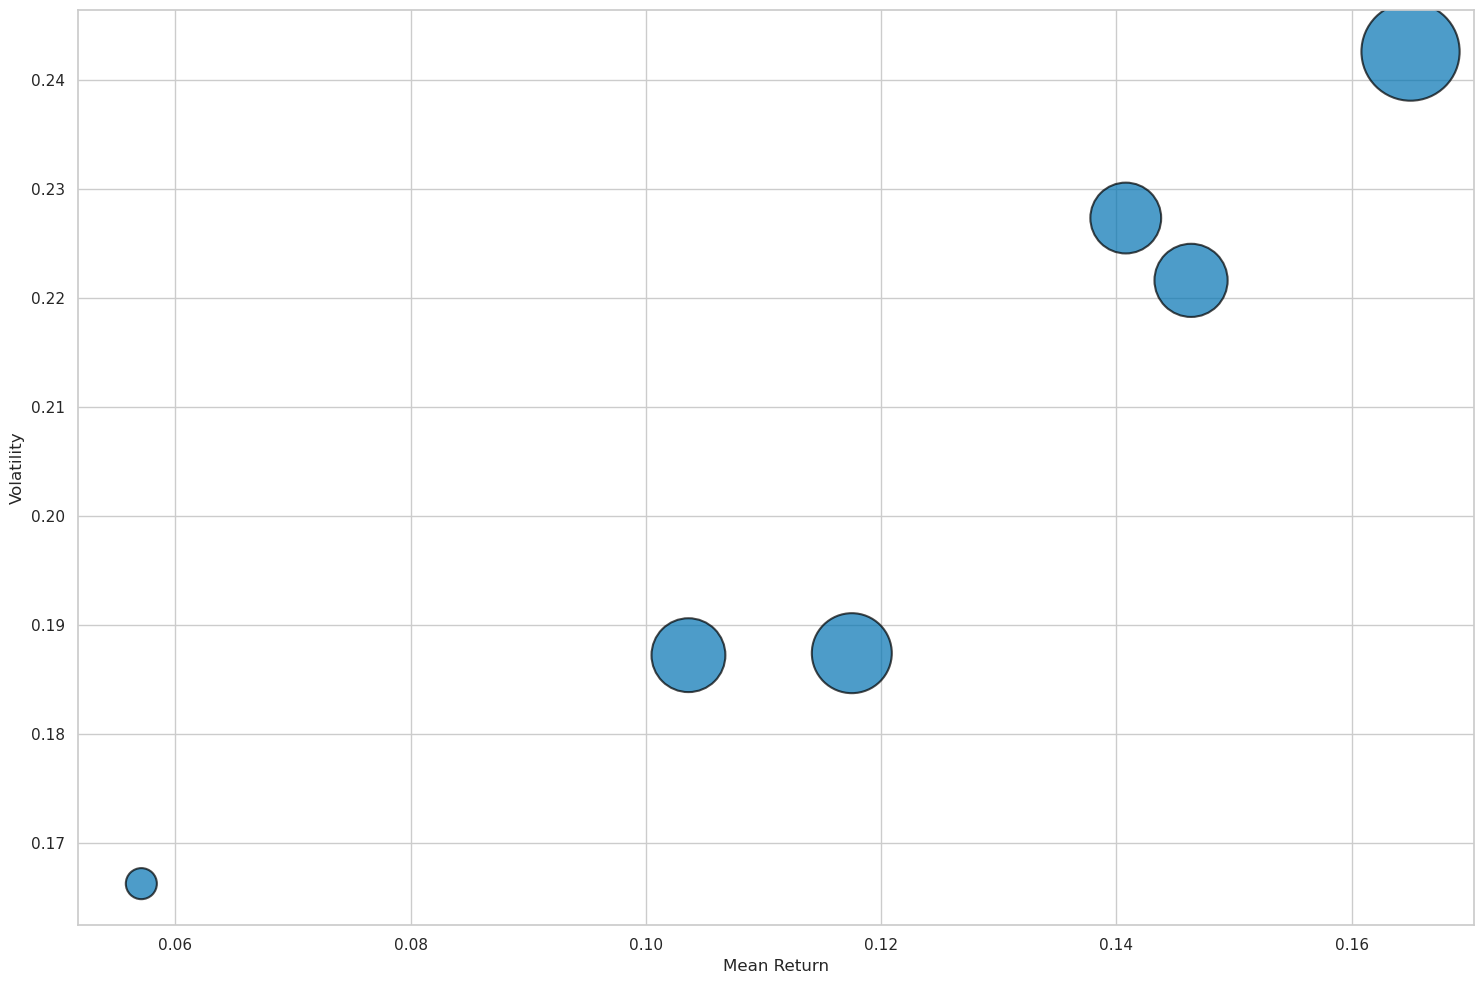

In [301]:
sns.set_theme(style="whitegrid", palette='colorblind')

# Create a figure and axis object with specific size
fig, ax = plt.subplots(figsize=(15, 10))


scatter = sns.scatterplot(
    data=plot_final,
    x="Mean Return",
    y="Volatility",
    size='Sharpe',  # Use the 'sharpe' column to set point sizes
    sizes=(500, 5000),  # Define the range for point sizes
    edgecolor='black',  # Dark edge color for better visibility
    linewidth=1.5,    # Slightly thicker edge
    alpha=0.7,  # Adding transparency to the points
    ax=ax,  # Use the specific axis object for plotting
    legend=False
)


# Adjust layout to make sure everything fits
plt.tight_layout()

# Save the plot with a transparent background
plt.savefig("data/charts/risk_return_tradeoff.png", transparent=True)

# Show the graph
plt.show()

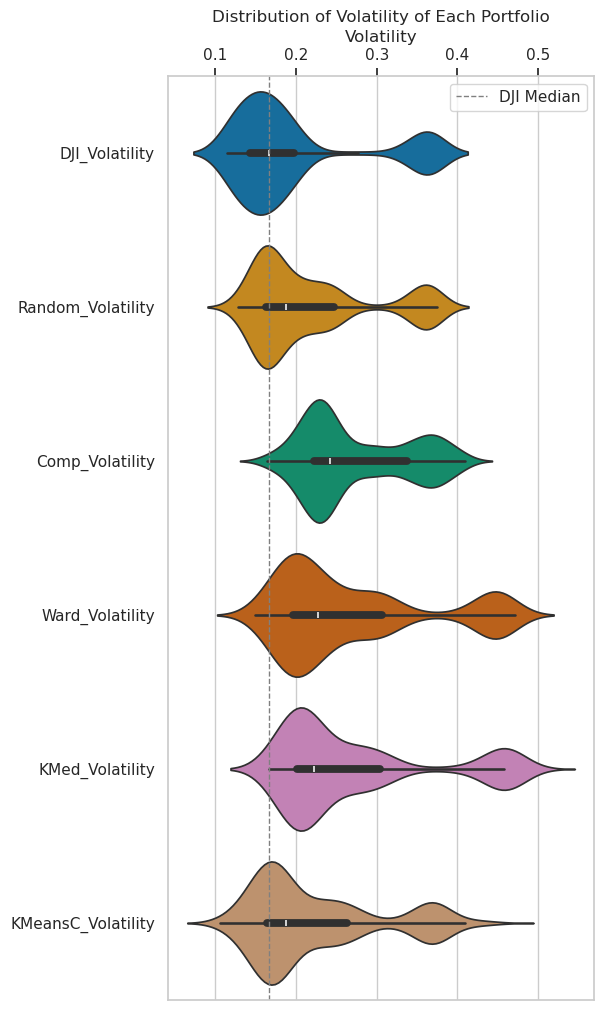

In [507]:
# Create a figure and axis
plt.figure(figsize=(5.5, 12))

# Create violin plots for each column
sns.violinplot(data=consolidated[['DJI_Volatility',
 'Random_Volatility',
 'Comp_Volatility',
 'Ward_Volatility',
 'KMed_Volatility',
 'KMeansC_Volatility']], orient = 'h')

# Calculate the median of 'DJI_Sharpe'
dji_median = consolidated['DJI_Volatility'].median()

# Add a horizontal line for the median of 'DJI_Sharpe'
plt.axvline(x=dji_median, color='gray', linestyle='--', linewidth=1, label=f'DJI Median')

# Set new category names
#new_category_names =  ['DJI', 'Random', 'Agg. Complete', 'Agg. Ward', 'K-Medoids', 'K-Means (Corr)']
#plt.gca().set_xticklabels(new_category_names)

# Customize the plot
plt.title('Distribution of Volatility of Each Portfolio')
#plt.xlabel('Portfolios')
plt.xlabel('Volatility')

# Move x-axis ticks to the top
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')

# Add legend to show the median line label
plt.legend()


# Save the plot as an image with a transparent background
plt.savefig("data/charts/volatility_distribution.png", transparent=True, bbox_inches='tight')

# Show the plot
plt.show()

# Display the plot
plt.show()

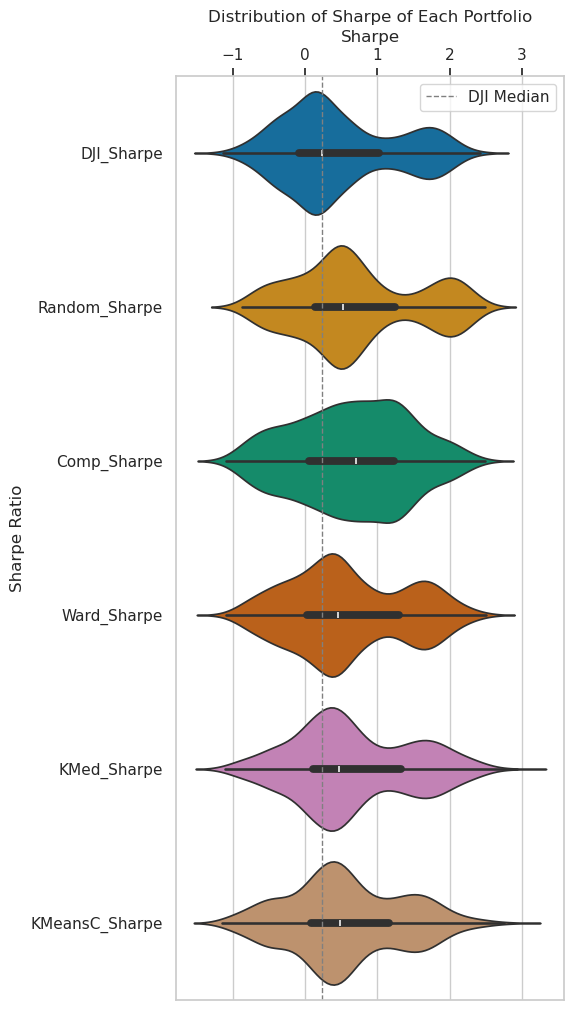

In [514]:

# Create a figure and axis
plt.figure(figsize=(5, 12))

# Create violin plots for each column
sns.violinplot(data=consolidated[['DJI_Sharpe',
                                  'Random_Sharpe',
                                  'Comp_Sharpe',
                                  'Ward_Sharpe',
                                  'KMed_Sharpe',
                                  'KMeansC_Sharpe']], orient = 'h')

# Calculate the median of 'DJI_Volatility'
dji_median = consolidated['DJI_Sharpe'].median()

# Add a horizontal line for the median of 'DJI_Volatility'
plt.axvline(x=dji_median, color='gray', linestyle='--', linewidth=1, label=f'DJI Median')

# Set new category names
#new_category_names = ['DJI', 'Random', 'Agg. Complete', 'Agg. Ward', 'K-Medoids', 'K-Means (Corr)']
#plt.gca().set_xticklabels(new_category_names)

# Customize the plot
plt.title('Distribution of Sharpe of Each Portfolio')
plt.xlabel('Sharpe')
plt.ylabel('Sharpe Ratio')

plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')

# Add legend to show the median line label
plt.legend()

# Save the plot as an image with a transparent background
plt.savefig("data/charts/sharpe_distribution.png", transparent=True, bbox_inches='tight')

# Show the plot
plt.show()

In [518]:
consolidated[['DJI_Sharpe','Random_Sharpe',
                                  'Comp_Sharpe',
                                  'Ward_Sharpe',
                                  'KMed_Sharpe',
                                  'KMeansC_Sharpe']].median()

DJI_Sharpe        0.238954
Random_Sharpe     0.528440
Comp_Sharpe       0.701425
Ward_Sharpe       0.454783
KMed_Sharpe       0.472847
KMeansC_Sharpe    0.478218
dtype: float64

In [520]:
consolidated[['DJI_Mean_Return','Random_Mean_Return',
                                  'Comp_Mean_Return',
                                  'Ward_Mean_Return',
                                  'KMed_Mean_Return',
                                  'KMeansC_Mean_Return']].median()

DJI_Mean_Return        0.057098
Random_Mean_Return     0.117499
Comp_Mean_Return       0.164999
Ward_Mean_Return       0.140789
KMed_Mean_Return       0.146340
KMeansC_Mean_Return    0.103611
dtype: float64

In [517]:
consolidated[['DJI_Volatility','Random_Volatility',
                                  'Comp_Volatility',
                                  'Ward_Volatility',
                                  'KMed_Volatility',
                                  'KMeansC_Volatility']].median()

DJI_Volatility        0.166313
Random_Volatility     0.187457
Comp_Volatility       0.242645
Ward_Volatility       0.227377
KMed_Volatility       0.221659
KMeansC_Volatility    0.187273
dtype: float64

In [281]:
import numpy as np
from scipy.stats import wilcoxon

def perform_wilcoxon_test(column1, column2, column1_name='Column 1', column2_name='Column 2', alpha=0.05):
    """
    Perform a Wilcoxon signed-rank test to compare two columns of data.
    
    Parameters:
    - column1: array-like, the first set of data (e.g., Sortino or Sharpe ratios for KMeans).
    - column2: array-like, the second set of data (e.g., Sortino or Sharpe ratios for DJI).
    - column1_name: str, name of the first column (default is 'Column 1').
    - column2_name: str, name of the second column (default is 'Column 2').
    - alpha: float, significance level (default is 0.05).
    
    Returns:
    - None, but prints out the results of the hypothesis test.
    """
    # Calculate the differences
    differences = column1 - column2
    
    # Perform the Wilcoxon signed-rank test
    statistic, p_value = wilcoxon(differences, alternative='greater')
    
    # Display results
    print(f"Wilcoxon test comparing {column1_name} and {column2_name}")
    print(f"Wilcoxon test statistic: {statistic}")
    print(f"P-value: {p_value}")
    
    # Conclusion based on p-value
    if p_value < alpha:
        print(f"Reject the null hypothesis: {column1_name} has significantly higher values than {column2_name}.")
    else:
        print(f"Fail to reject the null hypothesis: No significant difference in values between {column1_name} and {column2_name}.")


In [282]:
# Example usage for Mean Returns
perform_wilcoxon_test(
    consolidated['Comp_Mean_Return'], 
    consolidated['DJI_Mean_Return'], 
    column1_name='Agg. Complete Return', 
    column2_name='DJI Return'
)

perform_wilcoxon_test(
    consolidated['Ward_Mean_Return'], 
    consolidated['DJI_Mean_Return'], 
    column1_name='Agg. Ward Return', 
    column2_name='DJI Return'
)

perform_wilcoxon_test(
    consolidated['KMed_Mean_Return'], 
    consolidated['DJI_Mean_Return'], 
    column1_name='K-Medoids Return', 
    column2_name='DJI Return'
)

perform_wilcoxon_test(
    consolidated['KMeansC_Mean_Return'], 
    consolidated['DJI_Mean_Return'], 
    column1_name='K-Means (Corr) Return', 
    column2_name='DJI Return'
)

# Example usage for Volatility
perform_wilcoxon_test(
    consolidated['Comp_Volatility'], 
    consolidated['DJI_Volatility'], 
    column1_name='Agg. Complete Volatility', 
    column2_name='DJI Volatility'
)

perform_wilcoxon_test(
    consolidated['Ward_Volatility'], 
    consolidated['DJI_Volatility'], 
    column1_name='Agg. Ward Volatility', 
    column2_name='DJI Volatility'
)

perform_wilcoxon_test(
    consolidated['KMed_Volatility'], 
    consolidated['DJI_Volatility'], 
    column1_name='K-Medoids Volatility', 
    column2_name='DJI Volatility'
)

perform_wilcoxon_test(
    consolidated['KMeansC_Volatility'], 
    consolidated['DJI_Volatility'], 
    column1_name='K-Means (Corr) Volatility', 
    column2_name='DJI Volatility'
)

# Example usage for Sortino ratios
perform_wilcoxon_test(
    consolidated['Comp_Sortino'], 
    consolidated['DJI_Sortino'], 
    column1_name='Agg. Complete Sortino', 
    column2_name='DJI Sortino'
)

perform_wilcoxon_test(
    consolidated['Ward_Sortino'], 
    consolidated['DJI_Sortino'], 
    column1_name='Agg. Ward Sortino', 
    column2_name='DJI Sortino'
)

perform_wilcoxon_test(
    consolidated['KMed_Sortino'], 
    consolidated['DJI_Sortino'], 
    column1_name='K-Medoids Sortino', 
    column2_name='DJI Sortino'
)

perform_wilcoxon_test(
    consolidated['KMeansC_Sortino'], 
    consolidated['DJI_Sortino'], 
    column1_name='K-Means (Corr) Sortino', 
    column2_name='DJI Sortino'
)

# Example usage for Sharpe ratios
perform_wilcoxon_test(
    consolidated['Comp_Sharpe'], 
    consolidated['DJI_Sharpe'], 
    column1_name='Agg. Complete Sharpe', 
    column2_name='DJI Sharpe'
)

perform_wilcoxon_test(
    consolidated['Ward_Sharpe'], 
    consolidated['DJI_Sharpe'], 
    column1_name='Agg. Ward Sharpe', 
    column2_name='DJI Sharpe'
)

perform_wilcoxon_test(
    consolidated['KMed_Sharpe'], 
    consolidated['DJI_Sharpe'], 
    column1_name='K-Medoids Sharpe', 
    column2_name='DJI Sharpe'
)

perform_wilcoxon_test(
    consolidated['KMeansC_Sharpe'], 
    consolidated['DJI_Sharpe'], 
    column1_name='K-Means (Corr) Sharpe', 
    column2_name='DJI Sharpe'
)


Wilcoxon test comparing Agg. Complete Return and DJI Return
Wilcoxon test statistic: 443708.0
P-value: 3.0285683557867227e-66
Reject the null hypothesis: Agg. Complete Return has significantly higher values than DJI Return.
Wilcoxon test comparing Agg. Ward Return and DJI Return
Wilcoxon test statistic: 451111.0
P-value: 5.254543047521612e-72
Reject the null hypothesis: Agg. Ward Return has significantly higher values than DJI Return.
Wilcoxon test comparing K-Medoids Return and DJI Return
Wilcoxon test statistic: 484341.0
P-value: 6.717667607212131e-101
Reject the null hypothesis: K-Medoids Return has significantly higher values than DJI Return.
Wilcoxon test comparing K-Means (Corr) Return and DJI Return
Wilcoxon test statistic: 407575.0
P-value: 1.1635615291532784e-41
Reject the null hypothesis: K-Means (Corr) Return has significantly higher values than DJI Return.
Wilcoxon test comparing Agg. Complete Volatility and DJI Volatility
Wilcoxon test statistic: 550403.0
P-value: 4.269425

In [283]:
from scipy.stats import binomtest

def perform_binomial_test(column1, column2, column1_name='Column 1', column2_name='Column 2', alpha=0.05):
    """
    Perform a binomial test to compare the number of times one metric is greater than another.
    
    Parameters:
    - column1: array-like, the first set of data (e.g., returns, Sortino or Sharpe ratios for KMeans).
    - column2: array-like, the second set of data (e.g., returns, Sortino or Sharpe ratios for DJI).
    - column1_name: str, name of the first column (default is 'Column 1').
    - column2_name: str, name of the second column (default is 'Column 2').
    - alpha: float, significance level (default is 0.05).
    
    Returns:
    - None, but prints out the results of the hypothesis test.
    """
    # Count the number of times column1 is greater than column2
    successes = (column1 > column2).sum()
    n = len(column1)
    
    # Perform the binomial test using scipy.stats.binomtest
    test_result = binomtest(successes, n, p=0.5, alternative='greater')
    p_value = test_result.pvalue
    
    # Display results
    print(f"Binomial test comparing {column1_name} and {column2_name}")
    print(f"Number of successes: {successes} out of {n}: {successes*100/n:.2f}")
    print(f"P-value: {p_value}")
    
    # Conclusion based on p-value
    if p_value < alpha:
        print(f"Reject the null hypothesis: {column1_name} has significantly more periods with higher values than {column2_name}.")
    else:
        print(f"Fail to reject the null hypothesis: No significant difference in the number of periods with higher values between {column1_name} and {column2_name}.")


In [284]:
# Example usage for Mean Returns
perform_binomial_test(
    consolidated['Comp_Mean_Return'], 
    consolidated['DJI_Mean_Return'], 
    column1_name='Agg. Complete Return', 
    column2_name='DJI Return'
)

perform_binomial_test(
    consolidated['Ward_Mean_Return'], 
    consolidated['DJI_Mean_Return'], 
    column1_name='Agg. Ward Return', 
    column2_name='DJI Return'
)

perform_binomial_test(
    consolidated['KMed_Mean_Return'], 
    consolidated['DJI_Mean_Return'], 
    column1_name='K-Medoids Return', 
    column2_name='DJI Return'
)

perform_binomial_test(
    consolidated['KMeansC_Mean_Return'], 
    consolidated['DJI_Mean_Return'], 
    column1_name='K-Means (Corr) Return', 
    column2_name='DJI Return'
)

# Example usage for Volatility
perform_binomial_test(
    consolidated['Comp_Volatility'], 
    consolidated['DJI_Volatility'], 
    column1_name='Agg. Complete Volatility', 
    column2_name='DJI Volatility'
)

perform_binomial_test(
    consolidated['Ward_Volatility'], 
    consolidated['DJI_Volatility'], 
    column1_name='Agg. Ward Volatility', 
    column2_name='DJI Volatility'
)

perform_binomial_test(
    consolidated['KMed_Volatility'], 
    consolidated['DJI_Volatility'], 
    column1_name='K-Medoids Volatility', 
    column2_name='DJI Volatility'
)

perform_binomial_test(
    consolidated['KMeansC_Volatility'], 
    consolidated['DJI_Volatility'], 
    column1_name='K-Means (Corr) Volatility', 
    column2_name='DJI Volatility'
)

# Example usage for Sortino ratios
perform_binomial_test(
    consolidated['Comp_Sortino'], 
    consolidated['DJI_Sortino'], 
    column1_name='Agg. Complete Sortino', 
    column2_name='DJI Sortino'
)

perform_binomial_test(
    consolidated['Ward_Sortino'], 
    consolidated['DJI_Sortino'], 
    column1_name='Agg. Ward Sortino', 
    column2_name='DJI Sortino'
)

perform_binomial_test(
    consolidated['KMed_Sortino'], 
    consolidated['DJI_Sortino'], 
    column1_name='K-Medoids Sortino', 
    column2_name='DJI Sortino'
)

perform_binomial_test(
    consolidated['KMeansC_Sortino'], 
    consolidated['DJI_Sortino'], 
    column1_name='K-Means (Corr) Sortino', 
    column2_name='DJI Sortino'
)

# Example usage for Sharpe ratios
perform_binomial_test(
    consolidated['Comp_Sharpe'], 
    consolidated['DJI_Sharpe'], 
    column1_name='Agg. Complete Sharpe', 
    column2_name='DJI Sharpe'
)

perform_binomial_test(
    consolidated['Ward_Sharpe'], 
    consolidated['DJI_Sharpe'], 
    column1_name='Agg. Ward Sharpe', 
    column2_name='DJI Sharpe'
)

perform_binomial_test(
    consolidated['KMed_Sharpe'], 
    consolidated['DJI_Sharpe'], 
    column1_name='K-Medoids Sharpe', 
    column2_name='DJI Sharpe'
)

perform_binomial_test(
    consolidated['KMeansC_Sharpe'], 
    consolidated['DJI_Sharpe'], 
    column1_name='K-Means (Corr) Sharpe', 
    column2_name='DJI Sharpe'
)

Binomial test comparing Agg. Complete Return and DJI Return
Number of successes: 768 out of 1049: 73.21
P-value: 4.074428826660148e-53
Reject the null hypothesis: Agg. Complete Return has significantly more periods with higher values than DJI Return.
Binomial test comparing Agg. Ward Return and DJI Return
Number of successes: 784 out of 1049: 74.74
P-value: 2.186470848348458e-60
Reject the null hypothesis: Agg. Ward Return has significantly more periods with higher values than DJI Return.
Binomial test comparing K-Medoids Return and DJI Return
Number of successes: 838 out of 1049: 79.89
P-value: 3.340443075612794e-89
Reject the null hypothesis: K-Medoids Return has significantly more periods with higher values than DJI Return.
Binomial test comparing K-Means (Corr) Return and DJI Return
Number of successes: 727 out of 1049: 69.30
P-value: 6.711073926237715e-37
Reject the null hypothesis: K-Means (Corr) Return has significantly more periods with higher values than DJI Return.
Binomial t

In [ ]:
consolidated[['']]

In [134]:
dji.prices

,DJI
Date,
2013-01-02,13412.549805
2013-01-03,13391.360352
2013-01-04,13435.209961
2013-01-07,13384.290039
2013-01-08,13328.849609
...,...
2023-12-22,37385.968750
2023-12-26,37545.328125
2023-12-27,37656.519531


In [549]:
sim_port = eval(comp5s.loc['2022-12-01']['portfolio'])
sim_port = Portfolio('2022-12-01', '2024-11-01', tickers = sim_port)
sim_port.get_portf_sharpe()

0.06839426616437544

In [577]:
sim_portc = eval(kmeans5c.loc['2022-12-01']['portfolio'])
sim_portc = Portfolio('2022-12-01', '2024-11-01', tickers = sim_portc)
sim_portc.get_portf_sharpe()

0.04869475572658278

In [550]:
sim_dji = Portfolio('2022-12-01','2024-11-01', file = 'data/dji.csv')
sim_dji.get_portf_sharpe()

0.04563790918764033

In [551]:
sim_port.prices

,KLAC,GEN,PWR,BLDR,DXCM,LLY,COST,SMCI,WBD,TSLA,...,BIIB,AMD,MU,ENPH,MGM,HES,LULU,AXON,FCX,ETSY
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-01,383.705627,22.788580,151.274353,63.730000,118.029999,364.938416,486.761017,90.510002,11.63,194.699997,...,301.850006,77.480003,54.882088,314.000000,37.266930,140.395309,381.820007,185.550003,38.622551,139.389999
2022-12-02,382.556671,22.826942,152.610336,63.110001,118.110001,369.303925,477.747650,86.699997,11.55,194.860001,...,298.899994,74.980003,54.080956,336.000000,37.076946,141.031830,385.989990,188.830002,39.257000,140.490005
2022-12-05,381.584473,22.635122,150.367142,61.330002,116.559998,363.913574,472.076874,83.309998,11.15,182.449997,...,292.750000,73.620003,53.447975,335.820007,37.796883,137.673004,381.130005,184.009995,37.929562,137.210007
2022-12-06,376.350250,22.184338,149.140793,62.180000,116.830002,363.174469,464.831421,86.279999,10.61,179.820007,...,291.470001,70.269997,53.091915,309.730011,37.316925,132.796326,370.000000,169.429993,37.539139,135.009995
2022-12-07,381.113098,21.723961,147.864639,65.470001,117.910004,366.554565,465.613861,86.099998,10.74,174.039993,...,292.149994,70.139999,53.230381,317.049988,36.377003,131.973755,372.329987,170.160004,37.626980,130.130005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,579.117859,22.777929,213.802078,167.240005,122.169998,567.629944,653.721802,289.720001,11.27,252.539993,...,257.970001,139.600006,86.215637,133.990005,44.380001,145.688644,510.000000,259.029999,41.978100,84.949997
2023-12-26,587.784912,22.856678,214.421402,168.639999,123.550003,567.908569,656.661438,294.329987,11.50,256.609985,...,260.700012,143.410004,86.783829,137.339996,44.660000,147.746353,506.320007,258.109985,42.423828,82.589996
2023-12-27,587.884338,22.640120,215.709961,170.559998,123.730003,578.696167,663.809204,295.000000,11.49,261.440002,...,261.929993,146.070007,86.385109,135.630005,44.790001,147.696640,508.809998,259.079987,42.790318,82.389999


In [552]:
sim_port.prices

,KLAC,GEN,PWR,BLDR,DXCM,LLY,COST,SMCI,WBD,TSLA,...,BIIB,AMD,MU,ENPH,MGM,HES,LULU,AXON,FCX,ETSY
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-01,383.705627,22.788580,151.274353,63.730000,118.029999,364.938416,486.761017,90.510002,11.63,194.699997,...,301.850006,77.480003,54.882088,314.000000,37.266930,140.395309,381.820007,185.550003,38.622551,139.389999
2022-12-02,382.556671,22.826942,152.610336,63.110001,118.110001,369.303925,477.747650,86.699997,11.55,194.860001,...,298.899994,74.980003,54.080956,336.000000,37.076946,141.031830,385.989990,188.830002,39.257000,140.490005
2022-12-05,381.584473,22.635122,150.367142,61.330002,116.559998,363.913574,472.076874,83.309998,11.15,182.449997,...,292.750000,73.620003,53.447975,335.820007,37.796883,137.673004,381.130005,184.009995,37.929562,137.210007
2022-12-06,376.350250,22.184338,149.140793,62.180000,116.830002,363.174469,464.831421,86.279999,10.61,179.820007,...,291.470001,70.269997,53.091915,309.730011,37.316925,132.796326,370.000000,169.429993,37.539139,135.009995
2022-12-07,381.113098,21.723961,147.864639,65.470001,117.910004,366.554565,465.613861,86.099998,10.74,174.039993,...,292.149994,70.139999,53.230381,317.049988,36.377003,131.973755,372.329987,170.160004,37.626980,130.130005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,579.117859,22.777929,213.802078,167.240005,122.169998,567.629944,653.721802,289.720001,11.27,252.539993,...,257.970001,139.600006,86.215637,133.990005,44.380001,145.688644,510.000000,259.029999,41.978100,84.949997
2023-12-26,587.784912,22.856678,214.421402,168.639999,123.550003,567.908569,656.661438,294.329987,11.50,256.609985,...,260.700012,143.410004,86.783829,137.339996,44.660000,147.746353,506.320007,258.109985,42.423828,82.589996
2023-12-27,587.884338,22.640120,215.709961,170.559998,123.730003,578.696167,663.809204,295.000000,11.49,261.440002,...,261.929993,146.070007,86.385109,135.630005,44.790001,147.696640,508.809998,259.079987,42.790318,82.389999


In [553]:
sim_dji.prices

,DJI
Date,
2022-12-01,34395.011719
2022-12-02,34429.878906
2022-12-05,33947.101562
2022-12-06,33596.339844
2022-12-07,33597.921875
...,...
2023-12-22,37385.968750
2023-12-26,37545.328125
2023-12-27,37656.519531


In [581]:
prices = pd.DataFrame(sim_port.prices.sum(axis = 1))
prices.columns = ['Port_Price']
prices['DJI'] = sim_dji.prices['DJI']
prices['PortC_Price'] = sim_portc.prices.sum(axis = 1)
prices['Running Portfolio (Moderate Risk) Returns'] = (prices['Port_Price']/prices['Port_Price'].iloc[0]) - 1
prices['Running Portfolio (Conservative) Returns'] = (prices['PortC_Price']/prices['PortC_Price'].iloc[0]) - 1
prices['Running DJI Returns'] = (prices['DJI']/prices['DJI'].iloc[0]) - 1
prices.iloc[1:]

,Port_Price,DJI,PortC_Price,Running Portfolio (Moderate Risk) Returns,Running Portfolio (Conservative) Returns,Running DJI Returns
Date,,,,,,
2022-12-02,4586.411907,34429.878906,8325.155718,0.003724,0.006125,0.001014
2022-12-05,4508.836788,33947.101562,8206.215832,-0.013253,-0.008250,-0.013023
2022-12-06,4405.946249,33596.339844,8057.987404,-0.035770,-0.026164,-0.023221
2022-12-07,4414.891152,33597.921875,8082.454998,-0.033813,-0.023207,-0.023175
2022-12-08,4440.426181,33781.480469,8158.274048,-0.028224,-0.014044,-0.017838
...,...,...,...,...,...,...
2023-12-22,5702.391071,37385.968750,9286.974056,0.247953,0.122364,0.086959
2023-12-26,5740.243765,37545.328125,9271.264217,0.256237,0.120465,0.091592
2023-12-27,5773.649918,37656.519531,9305.801609,0.263548,0.124639,0.094825


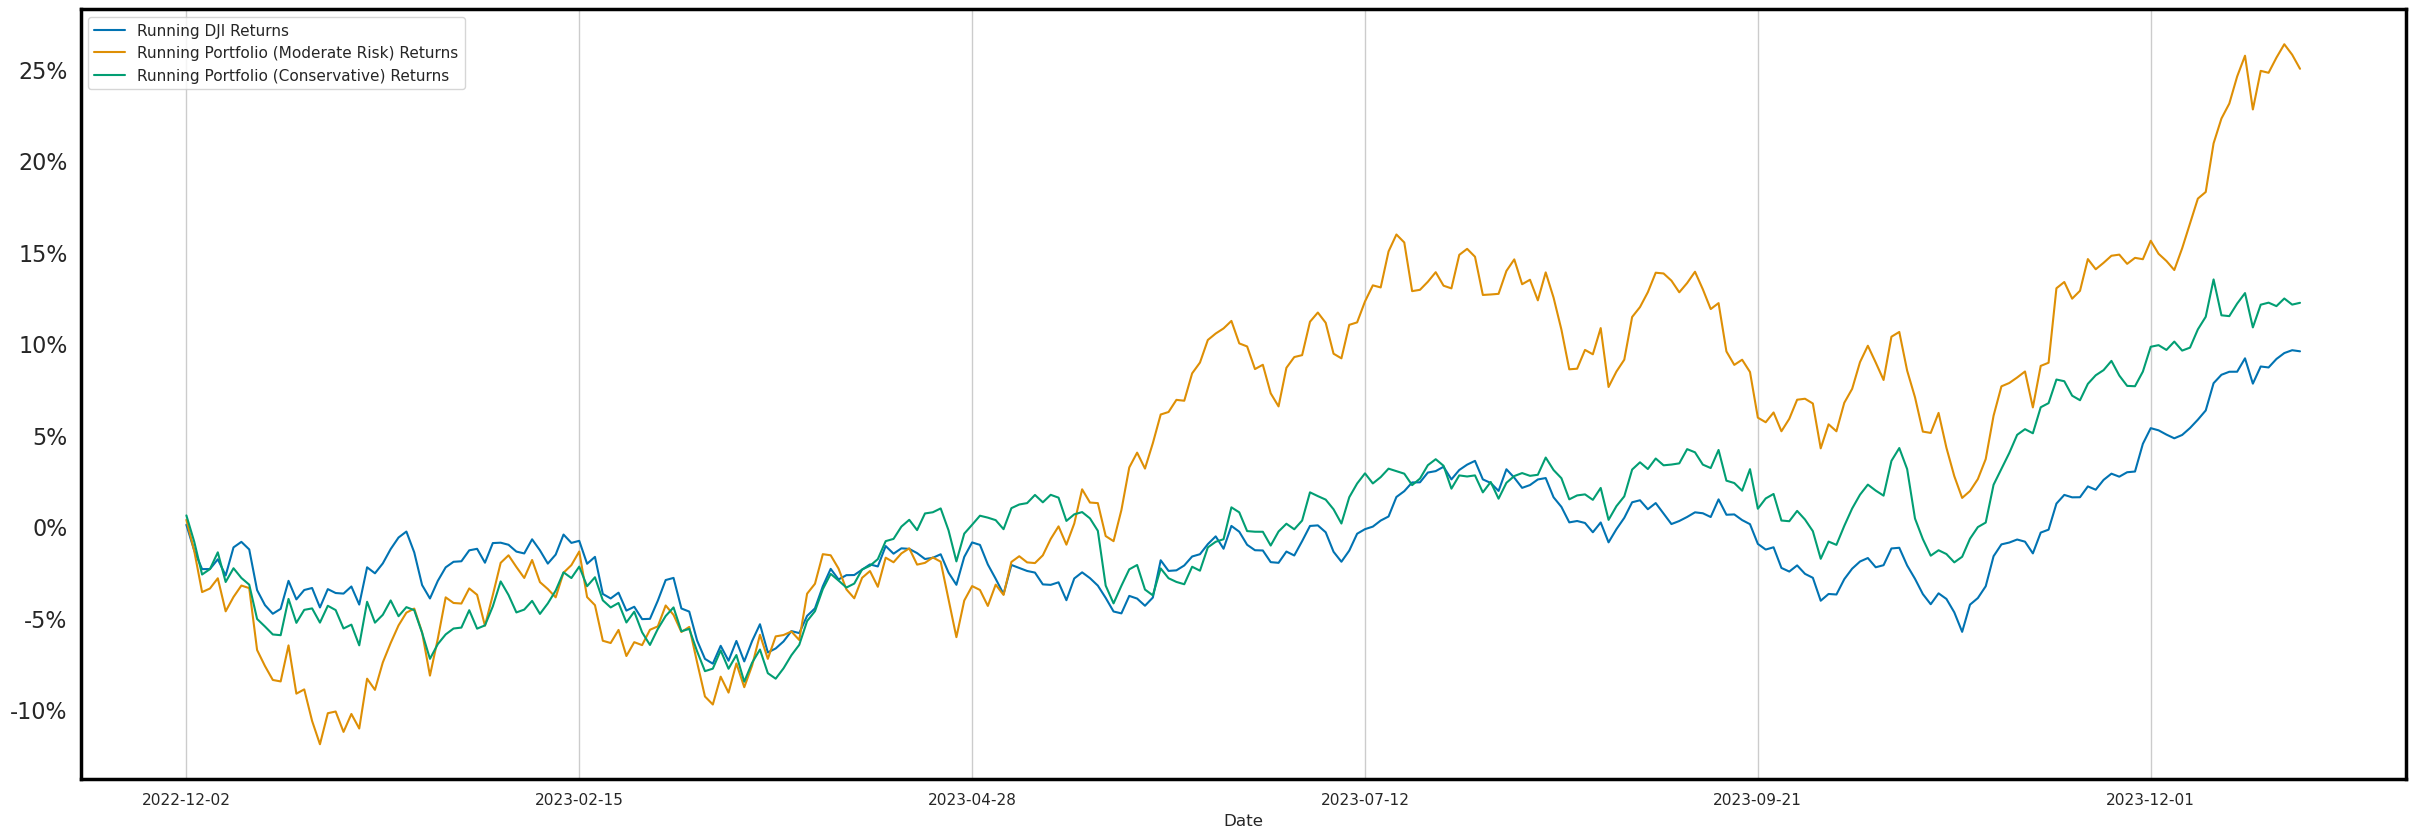

In [596]:

# Create a figure and axis object with specific size
fig, ax = plt.subplots(figsize=(30, 10))

# Plot the data
prices[['Running DJI Returns', 'Running Portfolio (Moderate Risk) Returns', 'Running Portfolio (Conservative) Returns']].iloc[1:].plot(ax=ax)

# Remove only horizontal gridlines
ax.grid(False, axis='y')

# Format the y-axis as a percentage using f-strings
yticks = ax.get_yticks()
ax.set_yticklabels([f'{y * 100:.0f}%' for y in yticks], fontsize=16)

# Make the plot border black
for spine in ax.spines.values():
    spine.set_linewidth(2.5)  # Increase border thickness
    spine.set_edgecolor('black')  # Set the edge color to black

# Save the plot as an image with a transparent background
plt.savefig("data/charts/simulated_stocks.png", transparent=True, bbox_inches='tight')

# Show the plot
plt.show()

In [593]:
prices.sort_values(by = 'Running Portfolio (Conservative) Returns', ascending = False)

,Port_Price,DJI,PortC_Price,Running Portfolio (Moderate Risk) Returns,Running Portfolio (Conservative) Returns,Running DJI Returns
Date,,,,,,
2023-12-13,5526.267249,37090.238281,9391.999239,0.209409,0.135057,0.078361
2023-12-19,5745.044068,37557.921875,9330.295620,0.257288,0.127599,0.091958
2023-12-27,5773.649918,37656.519531,9305.801609,0.263548,0.124639,0.094825
2023-12-22,5702.391071,37385.968750,9286.974056,0.247953,0.122364,0.086959
2023-12-29,5712.370477,37689.539062,9286.250891,0.250137,0.122277,0.095785
...,...,...,...,...,...,...
2023-03-15,4154.990806,31874.570312,7631.907814,-0.090691,-0.077657,-0.073279
2023-03-10,4145.307197,31909.640625,7621.058586,-0.092810,-0.078968,-0.072260
2023-03-22,4239.246013,32030.109375,7611.923058,-0.072252,-0.080072,-0.068757


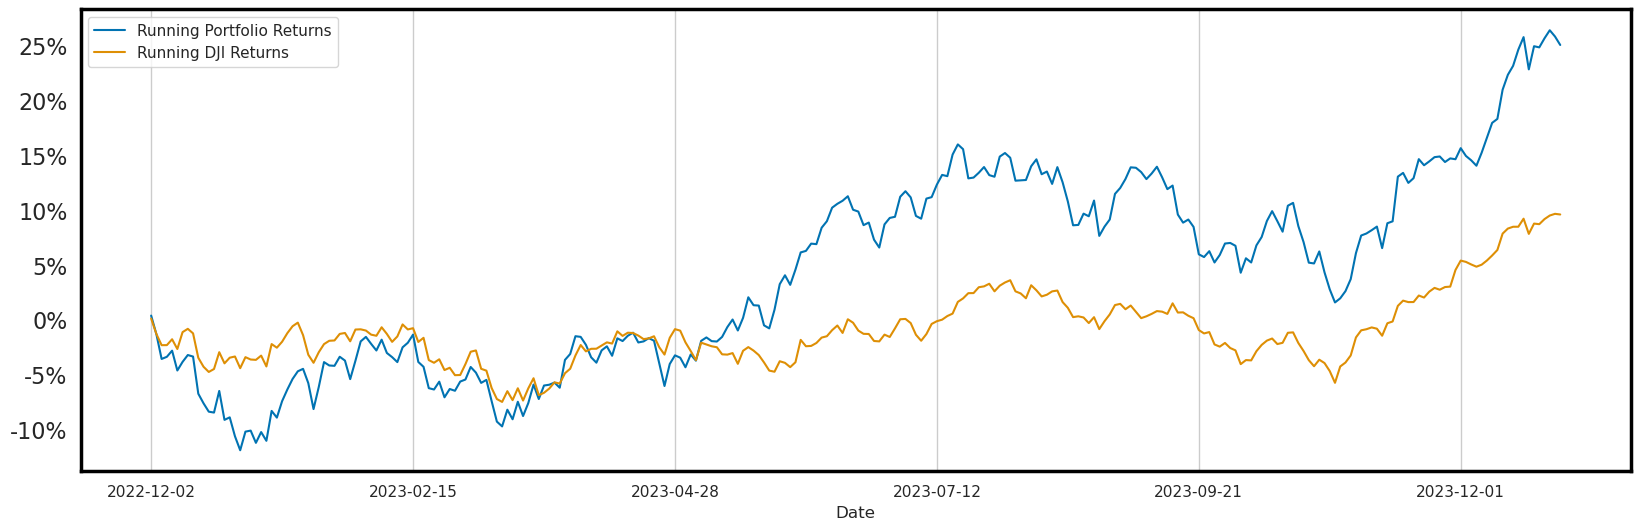

In [564]:

# Create a figure and axis object with specific size
fig, ax = plt.subplots(figsize=(20, 6))

# Plot the data
prices[['Running Portfolio Returns', 'Running DJI Returns']].iloc[1:].plot(ax=ax)

# Remove only horizontal gridlines
ax.grid(False, axis='y')

# Format the y-axis as a percentage using f-strings
yticks = ax.get_yticks()
ax.set_yticklabels([f'{y * 100:.0f}%' for y in yticks], fontsize=16)

# Make the plot border black
for spine in ax.spines.values():
    spine.set_linewidth(2.5)  # Increase border thickness
    spine.set_edgecolor('black')  # Set the edge color to black

# Save the plot as an image with a transparent background
plt.savefig("data/charts/simulated_stocks.png", transparent=True, bbox_inches='tight')

# Show the plot
plt.show()

In [576]:
prices['Multiplier'] = prices['Running Portfolio Returns']/prices['Running DJI Returns']
prices[(prices['Running Portfolio Returns']>0)].loc[:'2023-09-01'].sort_values(by = 'Running Portfolio Returns', ascending = False).head()

,Port_Price,DJI,Running Portfolio Returns,Running DJI Returns,Multiplier
Date,,,,,
2023-07-18,5298.705673,34951.929688,0.159608,0.016192,9.857312
2023-07-19,5278.800735,35061.210938,0.155252,0.019369,8.015447
2023-07-31,5262.847380,35559.531250,0.151760,0.033857,4.482363
2023-07-17,5256.374757,34585.351562,0.150344,0.005534,27.167608
2023-07-28,5247.876563,35459.289062,0.148484,0.030943,4.798665


In [574]:
prices.loc['2023-12-01']

Port_Price                    5283.042629
DJI                          36245.500000
Running Portfolio Returns        0.156180
Running DJI Returns              0.053801
Multiplier                       2.902917
Name: 2023-12-01, dtype: float64

<Axes: ylabel='Multiplier'>

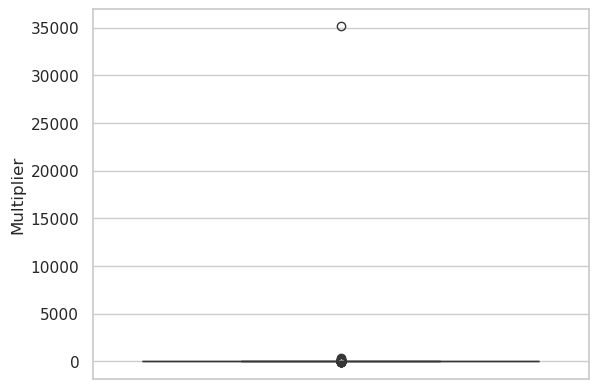

In [573]:
sns.boxplot(prices['Multiplier'])

In [380]:
from collections import Counter
stocks = []
for i in comp5s['portfolio']:
    stocks.extend(eval(i))


In [384]:
stocks_freq = pd.DataFrame.from_dict(Counter(stocks), orient='index').reset_index()
stocks_freq.columns = ['stock', 'frequency']
stocks_freq['perc_picked'] = stocks_freq['frequency']/1049
stocks_freq['perc_picked'] = stocks_freq['frequency']/1049
stocks_freq = stocks_freq.sort_values(by = 'perc_picked', ascending = False)
stocks_freq.head(30)

,stock,frequency,perc_picked
27,FSLR,1049,1.000000
19,TSLA,1049,1.000000
24,SMCI,1049,1.000000
17,ENPH,1049,1.000000
15,AXON,1049,1.000000
23,AMD,1004,0.957102
25,BLDR,991,0.944709
44,MTCH,980,0.934223
7,FCX,937,0.893232
33,NVDA,887,0.845567


In [606]:
sp500_train = Portfolio('2018-01-01', '2023-01-01')
sp500_train.stock_sharpe

,Sharpe
A,0.035576
AAL,-0.029085
AAPL,0.043486
ABBV,0.031824
ABT,0.033250
...,...
XYL,0.021670
YUM,0.026075
ZBH,0.003804
ZBRA,0.027744


In [602]:
sp500.stock_sharpe.reset_index()

,index,Sharpe
0,A,0.036107
1,AAL,0.000490
2,AAPL,0.049263
3,ABBV,0.041510
4,ABT,0.035829
...,...,...
449,XOM,0.012431
450,XYL,0.033633
451,YUM,0.028862
452,ZBH,0.015406


In [607]:
top_picks = pd.read_csv('data/addtl/top 30.csv')
top_picks.merge(sp500_train.stock_sharpe.reset_index(), left_on = 'Stock', right_on = 'index', how = 'left')

,Stock,Name,Year Established,Year of IPO,Industry,Market Cap Classification,Part of DJI,index,Sharpe
0,FSLR,"First Solar, Inc.",1999,2006,Solar Technology,Large-Cap,No,FSLR,0.020091
1,TSLA,"Tesla, Inc.",2003,2010,Automotive (Electric Vehicles),Mega-Cap,No,TSLA,0.033773
2,SMCI,Super Micro Computer,1993,2007,Information Technology,Mid-Cap,No,SMCI,0.029242
3,ENPH,"Enphase Energy, Inc.",2006,2012,Solar Technology,Large-Cap,No,ENPH,0.073256
4,AXON,"Axon Enterprise, Inc.",1993 (as Taser),2001,Defense and Security,Large-Cap,No,AXON,0.043572
5,AMD,Advanced Micro Devices,1969,1972,Semiconductors,Large-Cap,No,AMD,0.039593
6,BLDR,"Builders FirstSource, Inc.",1998,2005,Building Products,Large-Cap,No,BLDR,0.025868
7,MTCH,"Match Group, Inc.",2009,2015,Online Dating,Large-Cap,No,MTCH,0.007077
8,FCX,Freeport-McMoRan Inc.,1988,1995,Mining,Large-Cap,No,FCX,0.016696
9,NVDA,NVIDIA Corporation,1993,1999,Semiconductors,Mega-Cap,No,NVDA,0.026270


In [594]:
top_picks['Market Cap Classification'].value_counts()

Market Cap Classification
Large-Cap    23
Mega-Cap      4
Mid-Cap       3
Name: count, dtype: int64

In [388]:
top_picks['Market Cap Classification'].value_counts()

Market Cap Classification
Large-Cap    23
Mega-Cap      4
Mid-Cap       3
Name: count, dtype: int64

In [604]:
top_picks

,Stock,Name,Year Established,Year of IPO,Industry,Market Cap Classification,Part of DJI
0,FSLR,"First Solar, Inc.",1999,2006,Solar Technology,Large-Cap,No
1,TSLA,"Tesla, Inc.",2003,2010,Automotive (Electric Vehicles),Mega-Cap,No
2,SMCI,Super Micro Computer,1993,2007,Information Technology,Mid-Cap,No
3,ENPH,"Enphase Energy, Inc.",2006,2012,Solar Technology,Large-Cap,No
4,AXON,"Axon Enterprise, Inc.",1993 (as Taser),2001,Defense and Security,Large-Cap,No
5,AMD,Advanced Micro Devices,1969,1972,Semiconductors,Large-Cap,No
6,BLDR,"Builders FirstSource, Inc.",1998,2005,Building Products,Large-Cap,No
7,MTCH,"Match Group, Inc.",2009,2015,Online Dating,Large-Cap,No
8,FCX,Freeport-McMoRan Inc.,1988,1995,Mining,Large-Cap,No
9,NVDA,NVIDIA Corporation,1993,1999,Semiconductors,Mega-Cap,No
